# NES vs NLS (cytosol vs nucleus) classification baselines

Baseline classification methods for classifying sequences to be in or outside of the nucleus

In [99]:
import os
import sys
import itertools
import socket
import pickle
import importlib
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
from model_utils import single_train, ModelPerf, generate_model_perf
import model_utils
import plotting_utils

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)
plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

np.random.seed(27492)
SEED = 27492

In [2]:
importlib.reload(data_loader)
train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[4, 5, 6]))
valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[4, 5, 6]))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene


In [3]:
# Some general metrics about the data
print("Shape of training input:", train_data[0].shape)
print("Shape of validation input:", valid_data[0].shape)

Shape of training input: (7323, 5376)
Shape of validation input: (916, 5376)


In [4]:
rf_model, rf_results = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), train_data, valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8303360707638583
AUPRC:	 0.8325667322176611
Acc:	 0.7532751091703057
Rec:	 0.791497975708502
Prec:	 0.7607003891050583
F1:	 0.7757936507936507


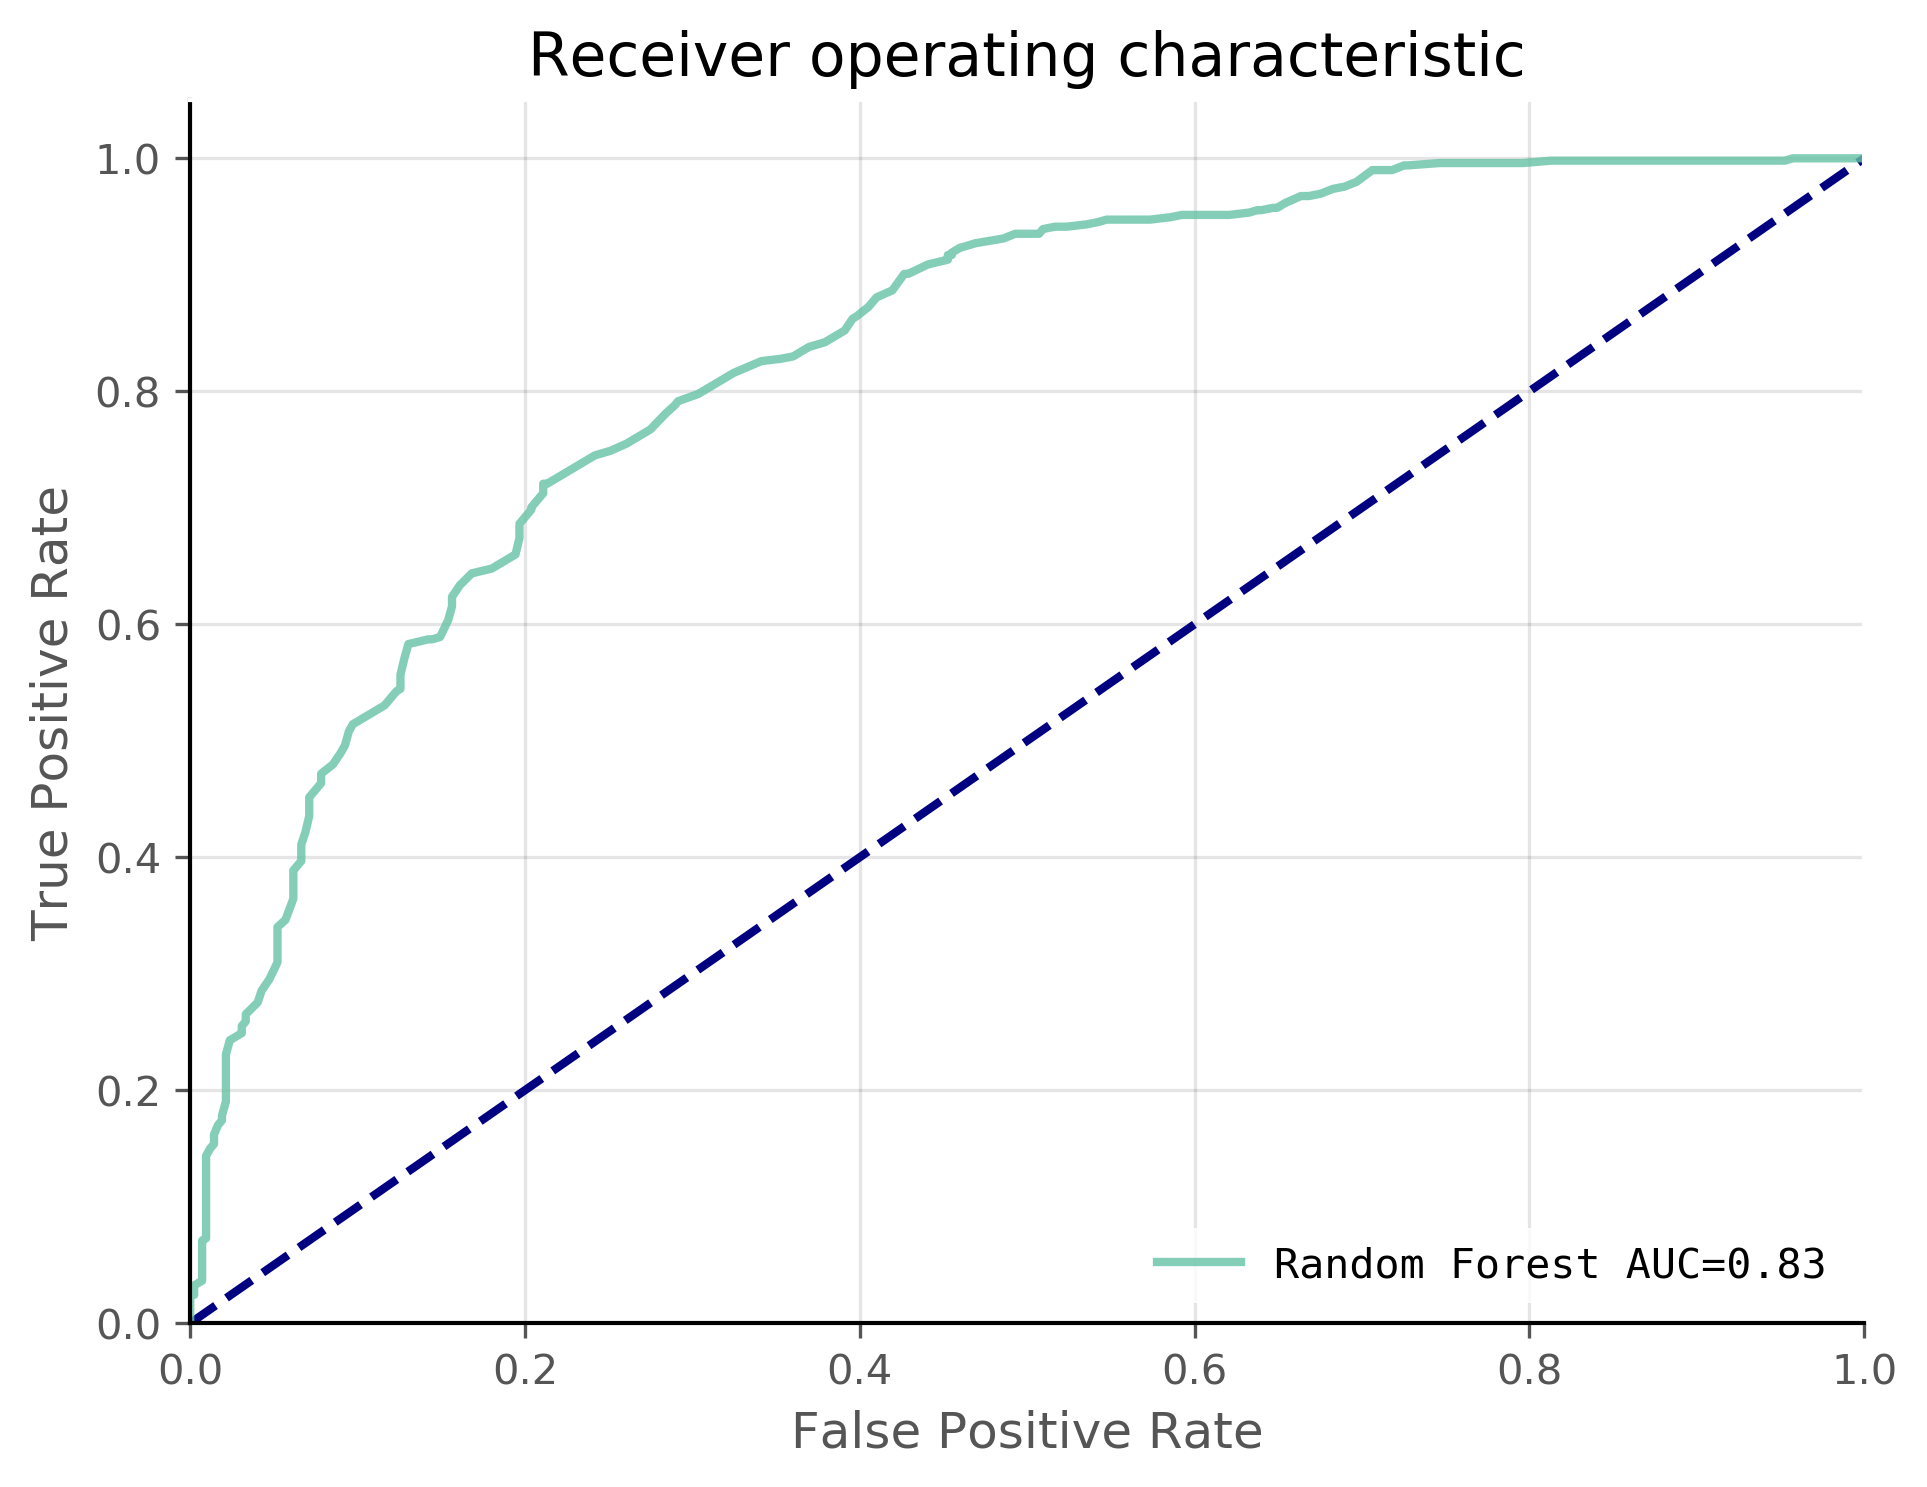

In [5]:
importlib.reload(plotting_utils)
plotting_utils.plot_auroc({"Random Forest": rf_results})

In [6]:
boosted_model, boosted_results = single_train(xgb.XGBClassifier(
    max_depth=3,
    eta=1,
    objective='binary:logistic',
    n_jobs=8,
    random_state=SEED,
), train_data, valid_data)

<class 'xgboost.sklearn.XGBClassifier'>
AUC:	 0.822788149740008
AUPRC:	 0.8286515895765624
Acc:	 0.7532751091703057
Rec:	 0.7894736842105263
Prec:	 0.76171875
F1:	 0.7753479125248509


In [7]:
lr_model, lr_results = single_train(LogisticRegression(solver='lbfgs'), train_data, valid_data)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
AUC:	 0.6652339927470883
AUPRC:	 0.6512008909809873
Acc:	 0.611353711790393
Rec:	 0.937246963562753
Prec:	 0.5875634517766497
F1:	 0.7223088923556941


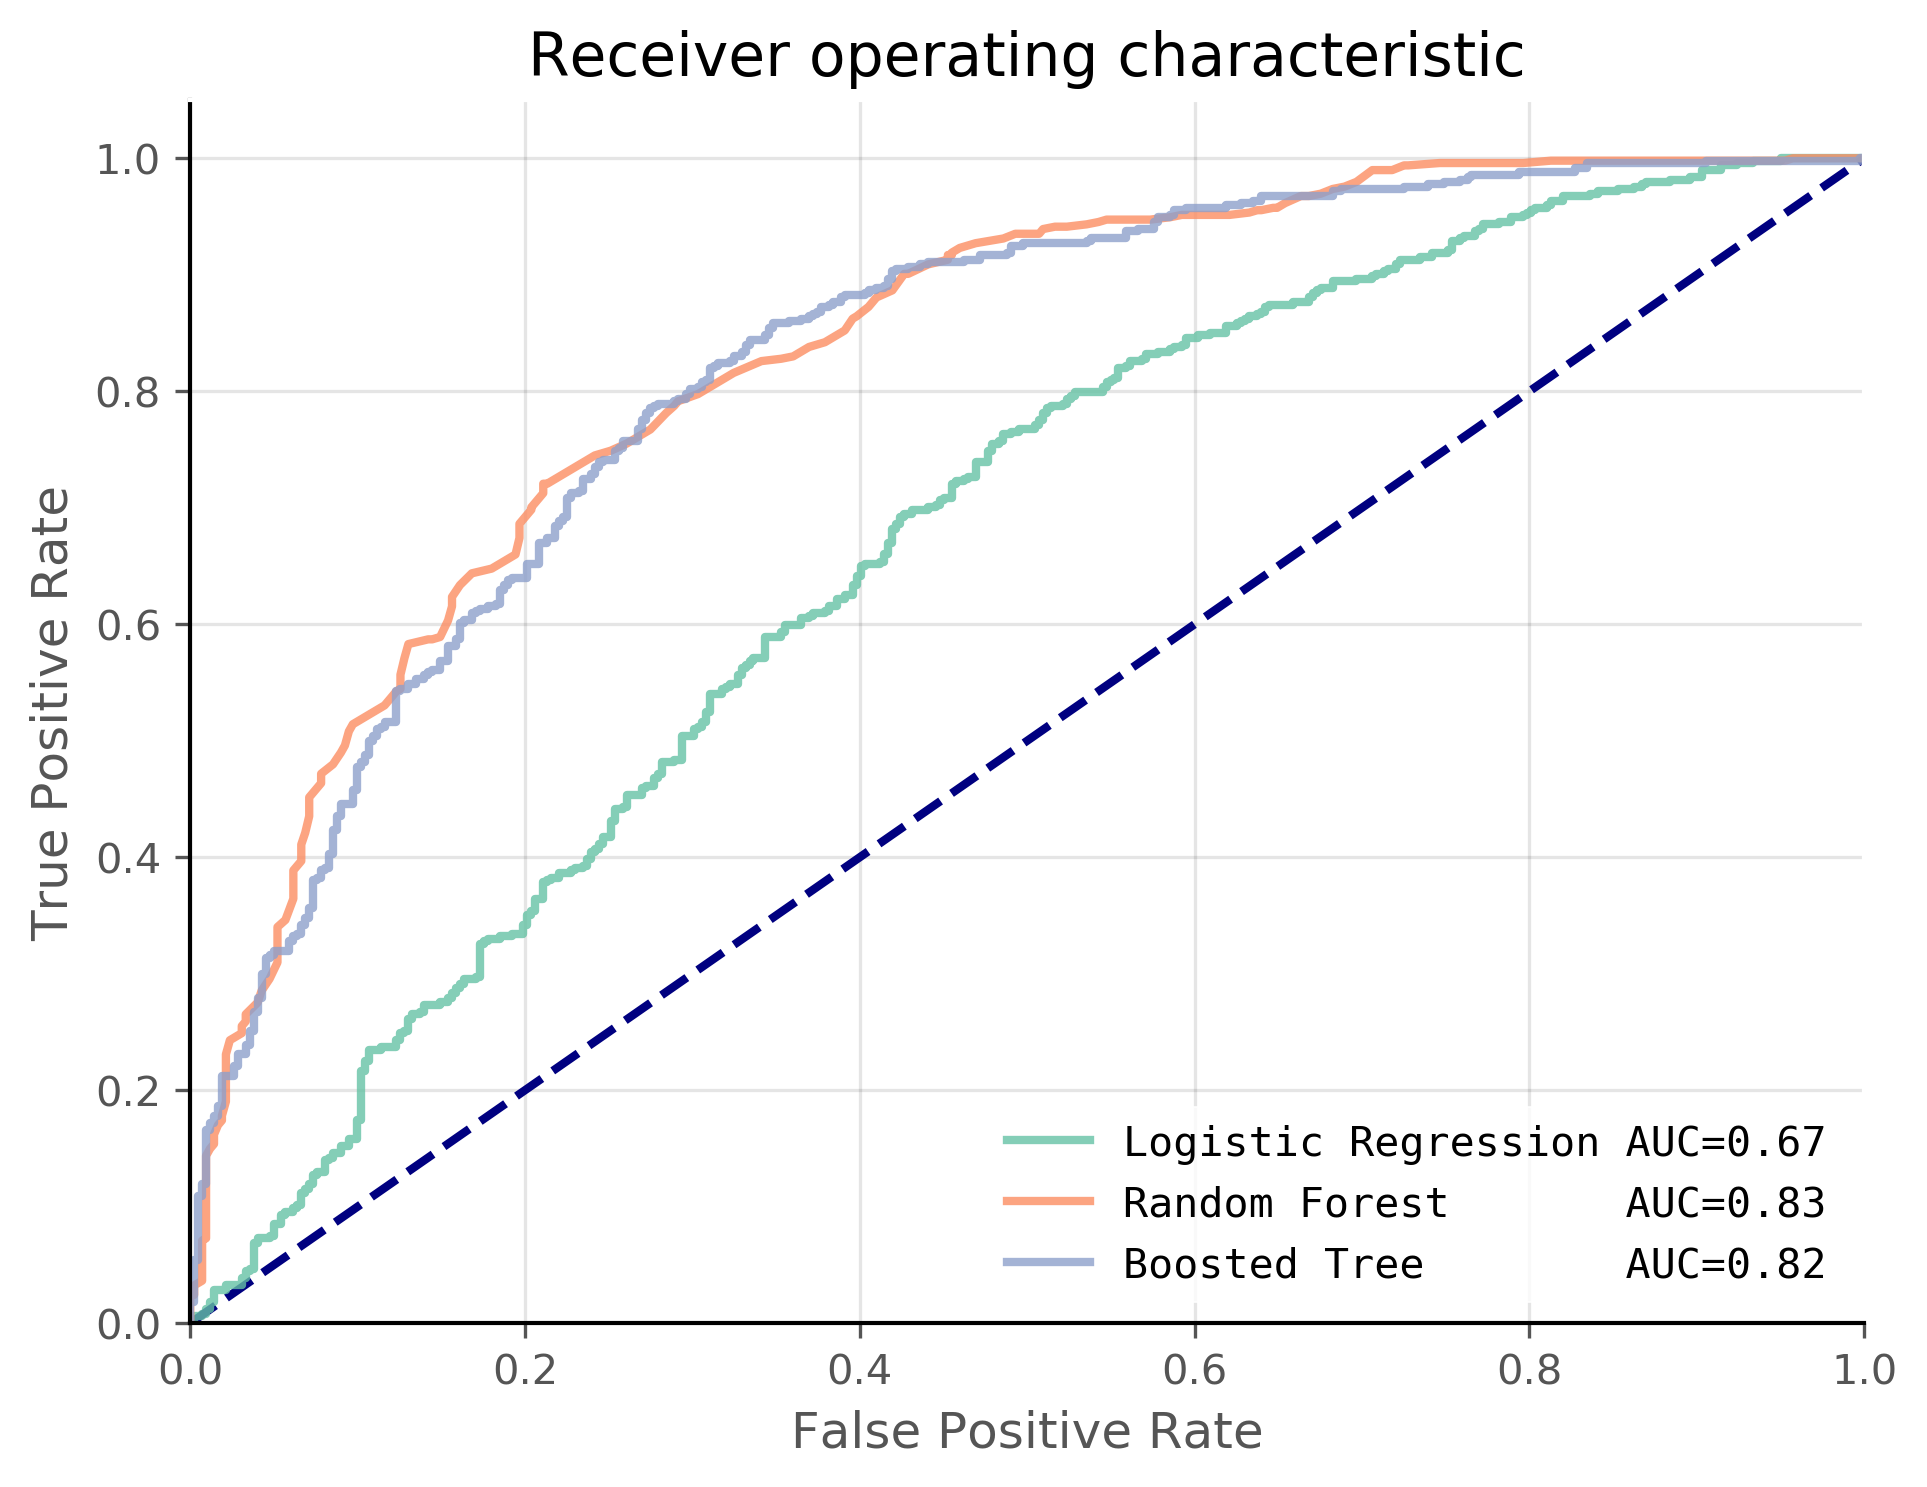

In [8]:
plotting_utils.plot_auroc({
    "Logistic Regression": lr_results,
    "Random Forest": rf_results,
    "Boosted Tree": boosted_results,
}, fname=os.path.join(PLOT_DIR, "nes_vs_nls_roc_baselines.png"))

In [9]:
def eval_random_classifier(train_data, valid_data, learn_pos_rate=True):
    """
    Evaluate performance of a random classifier, which simply "learns" the proportion of positives in training set
    valid_data should be tuple of (x, y)
    """
    print("Random classifier", "learning training positive rate" if learn_pos_rate else "")
    training_pos_rate = np.sum(train_data[1]) / len(train_data[1]) if learn_pos_rate else 0.5
    
    # Generate random uniform probabilities that follow training positive distribution
    valid_size = len(valid_data[1])
    negative_probs = np.random.uniform(0, 0.5, valid_size)
    positive_probs = np.random.uniform(0.5, 1, valid_size)
    all_probs = np.vstack((negative_probs, positive_probs))
    positive_indices = np.repeat(1, int(round(training_pos_rate * valid_size)))
    negative_indices = np.repeat(0, valid_size - len(positive_indices))
    indices = np.hstack((positive_indices, negative_indices))
    np.random.seed(242291)
    np.random.shuffle(indices)

    validation_probs = all_probs[indices, np.arange(valid_size)]
    validation_preds = np.round(validation_probs)
    print("Predicted at a positive rate of", np.sum(validation_preds) / len(validation_preds))
    
    retval = ModelPerf(
        auroc=metrics.roc_auc_score(valid_data[1].flatten(), validation_probs),
        auroc_curve=metrics.roc_curve(valid_data[1].flatten(), validation_probs),
        auprc=metrics.average_precision_score(valid_data[1].flatten(), validation_probs),
        auprc_curve=metrics.precision_recall_curve(valid_data[1].flatten(), validation_probs),
        accuracy=metrics.accuracy_score(valid_data[1], validation_preds),
        recall=metrics.recall_score(valid_data[1], validation_preds),
        precision=metrics.precision_score(valid_data[1], validation_preds),
        f1=metrics.f1_score(valid_data[1], validation_preds),
        ce_loss=metrics.log_loss(valid_data[1], validation_probs)
    )
    
    print("AUC:\t", retval.auroc)
    print("AUPRC:\t", retval.auprc)
    print("Acc:\t", retval.accuracy)
    print("Rec:\t", retval.recall)
    print("Prec:\t", retval.precision)
    print("F1:\t", retval.f1)
    return retval

eval_random_classifier(train_data, valid_data)
eval_random_classifier(train_data, valid_data, learn_pos_rate=False)

Random classifier learning training positive rate
Predicted at a positive rate of 0.5283842794759825
AUC:	 0.5072577086171498
AUPRC:	 0.5559514643326341
Acc:	 0.5131004366812227
Rec:	 0.5384615384615384
Prec:	 0.5495867768595041
F1:	 0.5439672801635991
Random classifier 
Predicted at a positive rate of 0.5
AUC:	 0.5118675288293647
AUPRC:	 0.5523785425420444
Acc:	 0.519650655021834
Rec:	 0.5182186234817814
Prec:	 0.5589519650655022
F1:	 0.5378151260504201


ModelPerf(auroc=0.5118675288293647, auroc_curve=(array([0.        , 0.        , 0.00236967, 0.00236967, 0.00473934,
       0.00473934, 0.007109  , 0.007109  , 0.00947867, 0.00947867,
       0.01658768, 0.01658768, 0.02369668, 0.02369668, 0.02606635,
       0.02606635, 0.02843602, 0.02843602, 0.03080569, 0.03080569,
       0.0450237 , 0.0450237 , 0.05687204, 0.05687204, 0.05924171,
       0.05924171, 0.06161137, 0.06161137, 0.06872038, 0.06872038,
       0.07582938, 0.07582938, 0.07819905, 0.07819905, 0.08056872,
       0.08056872, 0.08293839, 0.08293839, 0.08530806, 0.08530806,
       0.09004739, 0.09004739, 0.09241706, 0.09241706, 0.09478673,
       0.09478673, 0.0971564 , 0.0971564 , 0.09952607, 0.09952607,
       0.10189573, 0.10189573, 0.1042654 , 0.1042654 , 0.10900474,
       0.10900474, 0.11374408, 0.11374408, 0.11611374, 0.11611374,
       0.12085308, 0.12085308, 0.12322275, 0.12322275, 0.12796209,
       0.12796209, 0.13270142, 0.13270142, 0.13507109, 0.13507109,
       0.1374

In [10]:
smaller_kmer_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[2, 3, 4, 5]))
smaller_kmer_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[2, 3, 4, 5]))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene


In [11]:
print("Shape of small-kmer training input:", smaller_kmer_train_data[0].shape)
print("Shape of small-kmer validation input:", smaller_kmer_valid_data[0].shape)

Shape of small-kmer training input: (7323, 1360)
Shape of small-kmer validation input: (916, 1360)


In [12]:
smaller_kmer_lr_model, smaller_kmer_lr_results = single_train(LogisticRegression(solver='lbfgs'), smaller_kmer_train_data, smaller_kmer_valid_data)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
AUC:	 0.6851267340790913
AUPRC:	 0.6590136778268918
Acc:	 0.6473799126637555
Rec:	 0.8319838056680162
Prec:	 0.631336405529954
F1:	 0.7179039301310044


In [13]:
smaller_kmer_rf_model, smaller_kmer_rf_results = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), smaller_kmer_train_data, smaller_kmer_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8403064259262811
AUPRC:	 0.8341964012728617
Acc:	 0.75764192139738
Rec:	 0.7651821862348178
Prec:	 0.78099173553719
F1:	 0.7730061349693251


In [14]:
smaller_kmer_boosted_model, smaller_kmer_boosted_results = single_train(xgb.XGBClassifier(
    max_depth=3,
    eta=1,
    objective='binary:logistic',
    n_jobs=8,
    random_state=SEED,
), smaller_kmer_train_data, smaller_kmer_valid_data)

<class 'xgboost.sklearn.XGBClassifier'>
AUC:	 0.8332309994819349
AUPRC:	 0.8283413932722083
Acc:	 0.7663755458515283
Rec:	 0.8157894736842105
Prec:	 0.7661596958174905
F1:	 0.7901960784313726


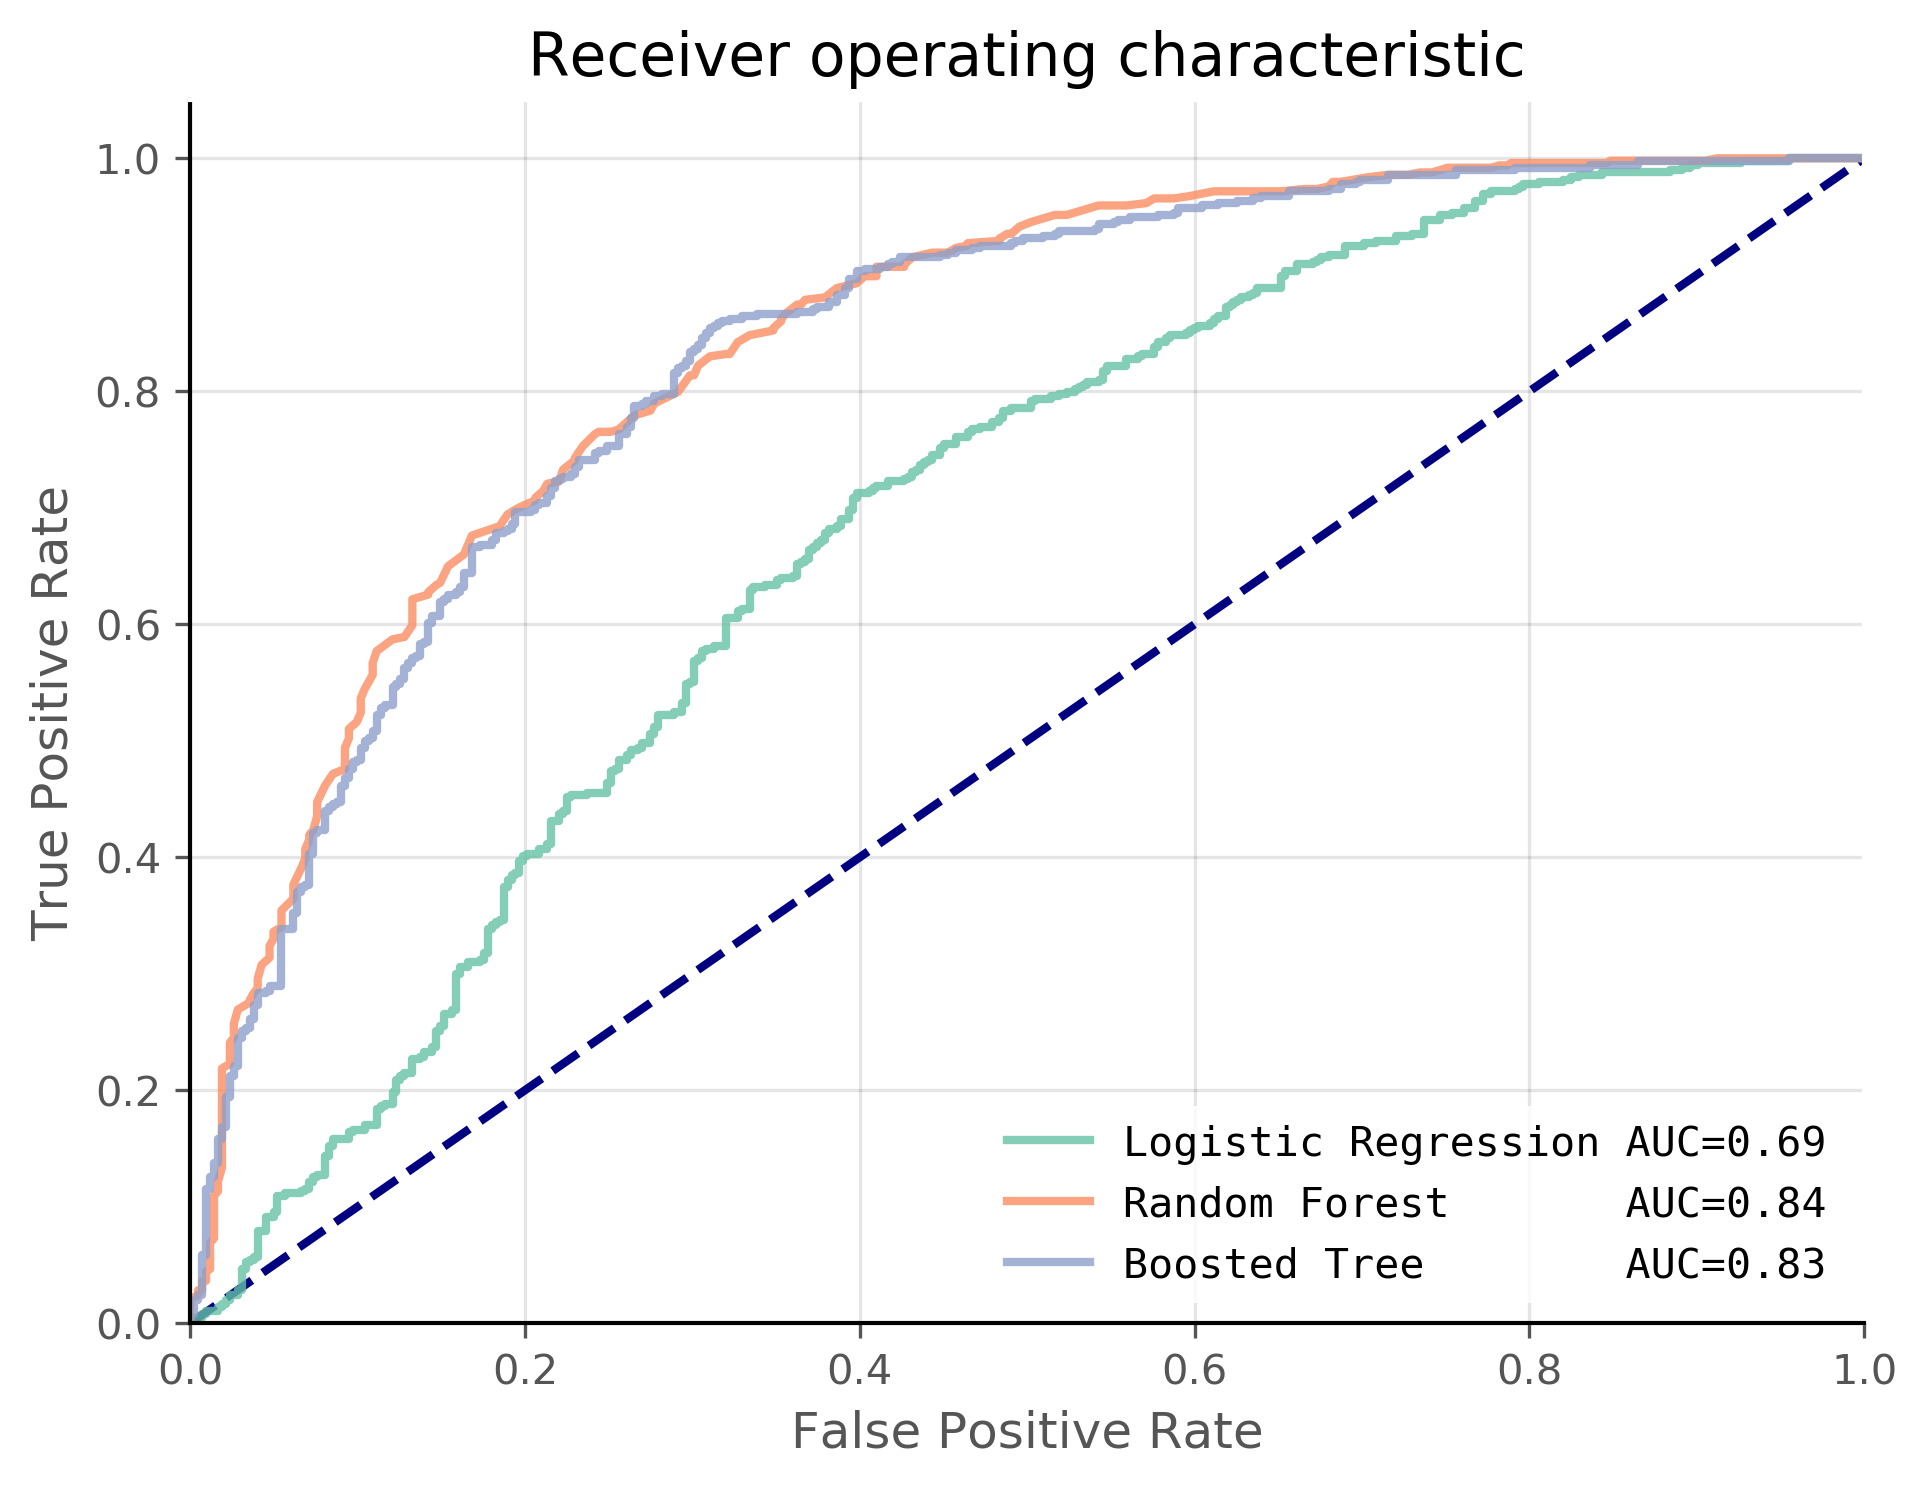

In [15]:
plotting_utils.plot_auroc({
    "Logistic Regression": smaller_kmer_lr_results,
    "Random Forest": smaller_kmer_rf_results,
    "Boosted Tree": smaller_kmer_boosted_results,
}, fname=os.path.join(PLOT_DIR, "nes_vs_nls_roc_baselines_small_kmer.png"))

In [16]:
expanded_kmer_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[2, 3, 4, 5, 6]))
expanded_kmer_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[2, 3, 4, 5, 6]))
print("Shape of expanded-kmer training input:", expanded_kmer_train_data[0].shape)
print("Shape of expanded-kmer validation input:", expanded_kmer_valid_data[0].shape)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of expanded-kmer training input: (7323, 5456)
Shape of expanded-kmer validation input: (916, 5456)


In [17]:
expanded_kmer_lr_model, expanded_kmer_lr_results = single_train(LogisticRegression(solver='lbfgs'), expanded_kmer_train_data, expanded_kmer_valid_data)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
AUC:	 0.6884797666788188
AUPRC:	 0.6613544801523534
Acc:	 0.6506550218340611
Rec:	 0.8319838056680162
Prec:	 0.6342592592592593
F1:	 0.7197898423817863


In [18]:
expanded_kmer_rf_model, expanded_kmer_rf_results = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), expanded_kmer_train_data, expanded_kmer_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8323699560604025
AUPRC:	 0.8332444820225529
Acc:	 0.7554585152838428
Rec:	 0.791497975708502
Prec:	 0.763671875
F1:	 0.7773359840954274


In [19]:
expanded_kmer_boosted_model, expanded_kmer_boosted_results = single_train(xgb.XGBClassifier(
    max_depth=3,
    eta=1,
    objective='binary:logistic',
    n_jobs=8,
    random_state=SEED,
), expanded_kmer_train_data, expanded_kmer_valid_data)

<class 'xgboost.sklearn.XGBClassifier'>
AUC:	 0.8314609436460272
AUPRC:	 0.8346723201760201
Acc:	 0.7641921397379913
Rec:	 0.8016194331983806
Prec:	 0.7704280155642024
F1:	 0.7857142857142858


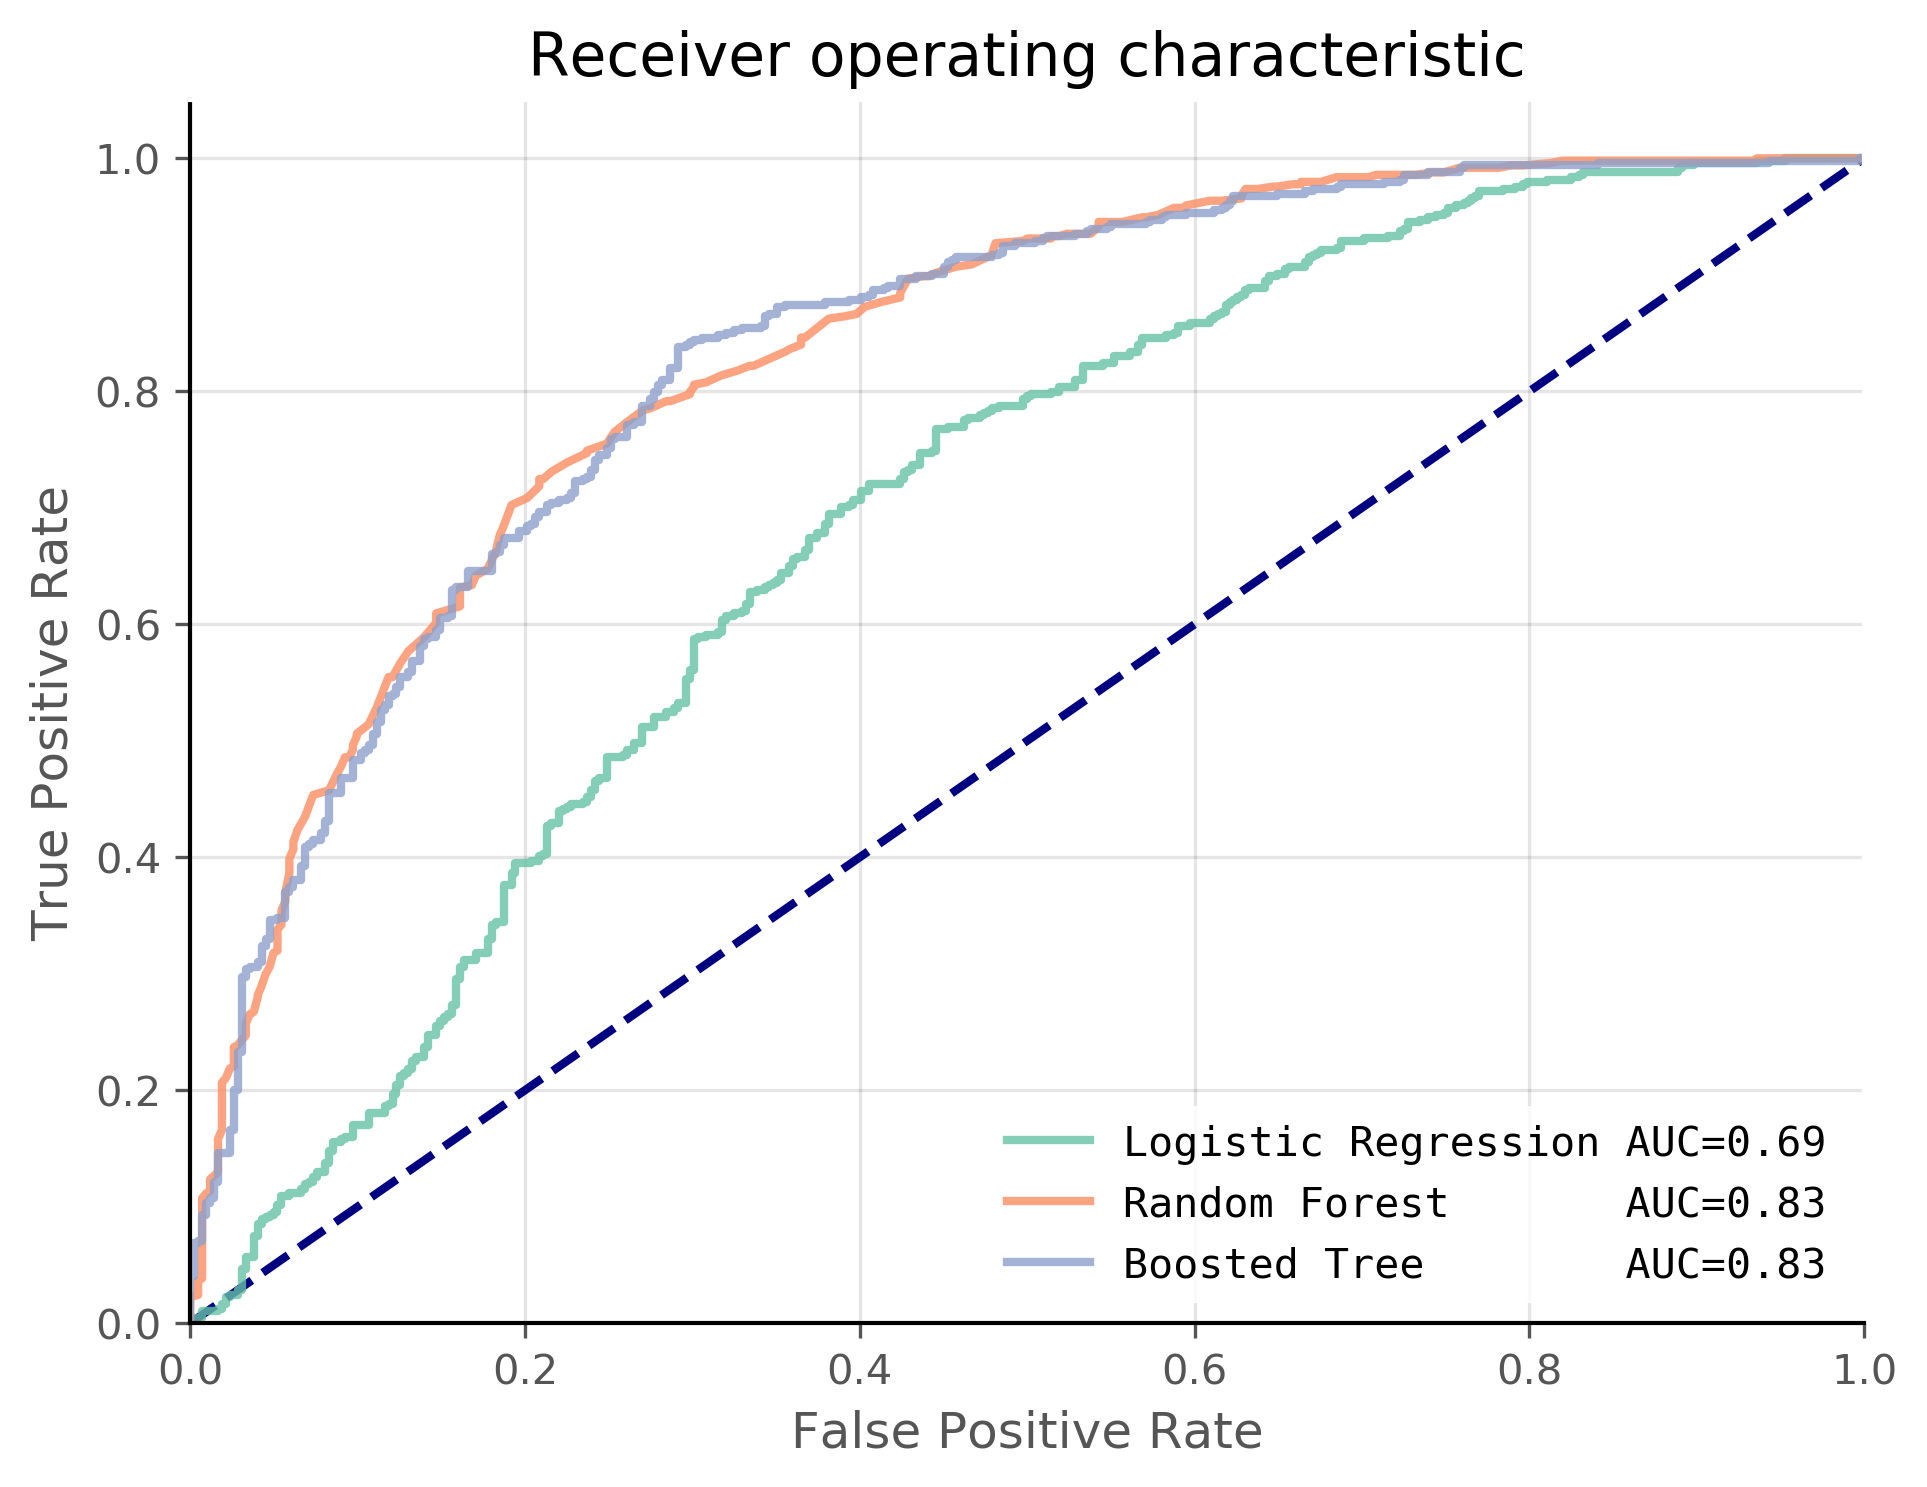

In [20]:
plotting_utils.plot_auroc({
    "Logistic Regression": expanded_kmer_lr_results,
    "Random Forest": expanded_kmer_rf_results,
    "Boosted Tree": expanded_kmer_boosted_results,
}, fname=os.path.join(PLOT_DIR, "nes_vs_nls_roc_baselines_expanded_kmer.png"))

## Individual kmer size investigation

At this point, it appears that the random forest model is a consistently strong performer. We will use this model to see which kmer featurization is most informative.

In [21]:
kmer_rf_results = []
for kmer_size in range(1, 10):
    kmer_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[kmer_size]))
    kmer_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[kmer_size]))
    print("Shape of {}-mer training input:   {}".format(kmer_size, kmer_train_data[0].shape))
    print("Shape of {}-mer validation input: {}".format(kmer_size, kmer_valid_data[0].shape))
    
    kmer_rf_results.append(single_train(RandomForestClassifier(
        n_estimators=250,
        n_jobs=8,
        class_weight="balanced",
    ), kmer_train_data, kmer_valid_data)[1])

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 1-mer training input:   (7323, 4)
Shape of 1-mer validation input: (916, 4)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.6340421551509104
AUPRC:	 0.6477035980353878
Acc:	 0.5895196506550219
Rec:	 0.6275303643724697
Prec:	 0.6175298804780877
F1:	 0.6224899598393575


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 2-mer training input:   (7323, 16)
Shape of 2-mer validation input: (916, 16)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.7899149989446822
AUPRC:	 0.7927069136933738
Acc:	 0.7117903930131004
Rec:	 0.7246963562753036
Prec:	 0.7366255144032922
F1:	 0.7306122448979592


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 3-mer training input:   (7323, 64)
Shape of 3-mer validation input: (916, 64)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8275059001861198
AUPRC:	 0.8212877357496832
Acc:	 0.75
Rec:	 0.7489878542510121
Prec:	 0.7789473684210526
F1:	 0.7636738906088751


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 4-mer training input:   (7323, 256)
Shape of 4-mer validation input: (916, 256)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8332286010322927
AUPRC:	 0.8254782252551434
Acc:	 0.7478165938864629
Rec:	 0.7408906882591093
Prec:	 0.7803837953091685
F1:	 0.7601246105919003


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 5-mer training input:   (7323, 1024)
Shape of 5-mer validation input: (916, 1024)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8271413358405129
AUPRC:	 0.8257529333425155
Acc:	 0.74235807860262
Rec:	 0.7793522267206477
Prec:	 0.751953125
F1:	 0.7654075546719682


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 6-mer training input:   (7323, 4096)
Shape of 6-mer validation input: (916, 4096)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8197517124930445
AUPRC:	 0.8236504366287768
Acc:	 0.7379912663755459
Rec:	 0.8178137651821862
Prec:	 0.7292418772563177
F1:	 0.7709923664122137


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 7-mer training input:   (7323, 16384)
Shape of 7-mer validation input: (916, 16384)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8039075541569929
AUPRC:	 0.8129497424072458
Acc:	 0.7237991266375546
Rec:	 0.7995951417004049
Prec:	 0.7194899817850637
F1:	 0.7574304889741131


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 8-mer training input:   (7323, 65536)
Shape of 8-mer validation input: (916, 65536)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8101243356294491
AUPRC:	 0.8070870889033949
Acc:	 0.7390829694323144
Rec:	 0.8421052631578947
Prec:	 0.7209705372616985
F1:	 0.776844070961718


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of 9-mer training input:   (7323, 262144)
Shape of 9-mer validation input: (916, 262144)
<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8064834890726635
AUPRC:	 0.7985018934885028
Acc:	 0.732532751091703
Rec:	 0.9089068825910931
Prec:	 0.6918335901386748
F1:	 0.7856517935258093


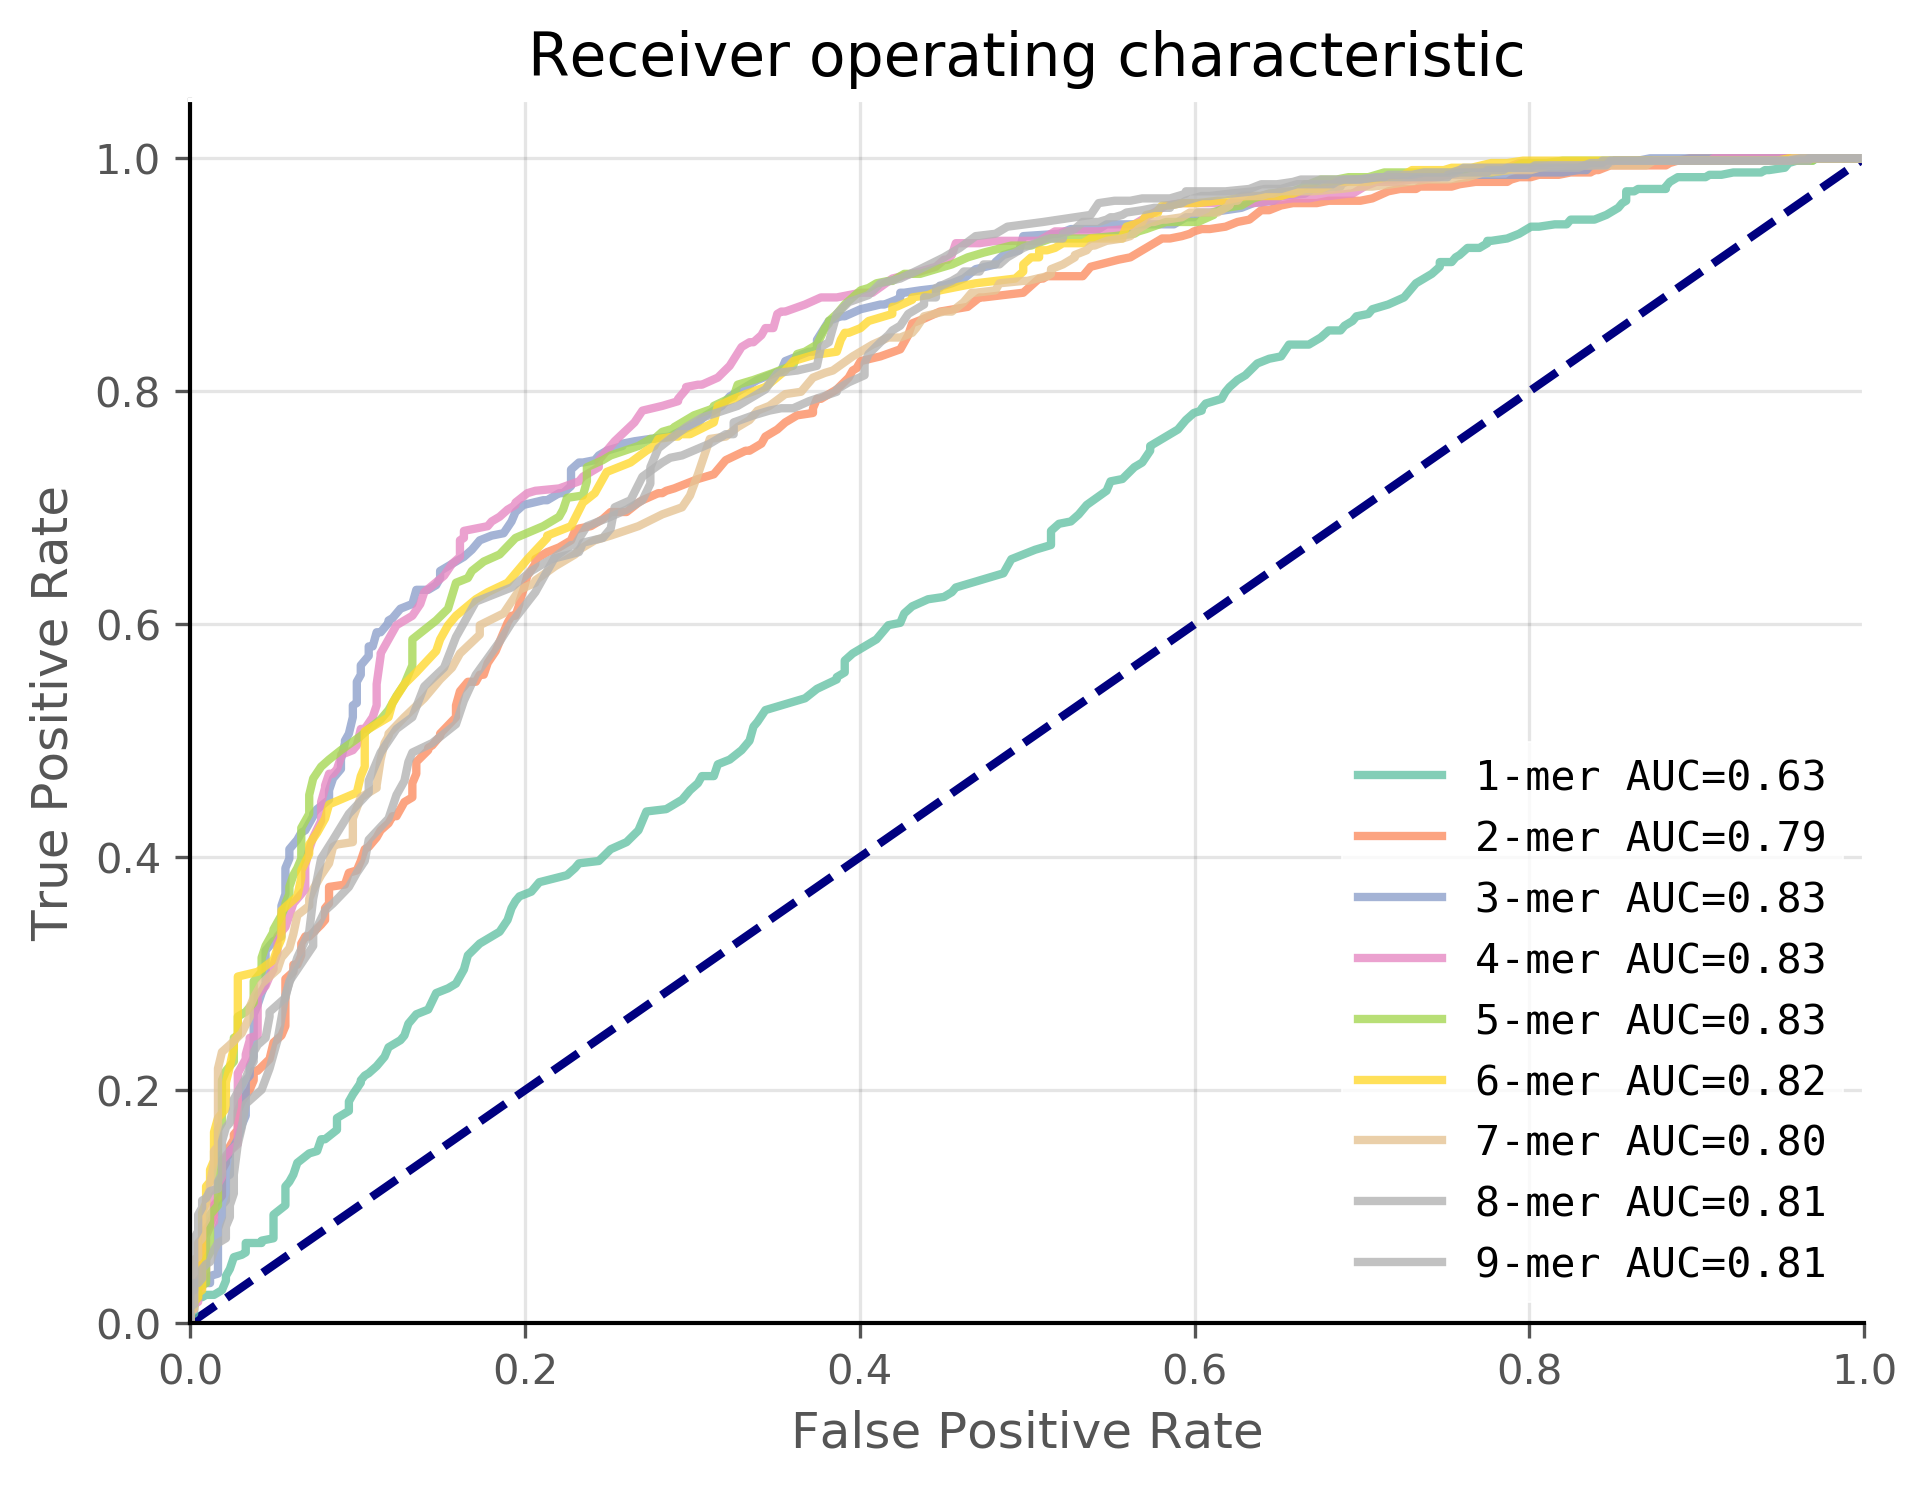

In [22]:
kmer_auroc_curves = {}
for kmer_size, perf in zip(range(1, 10), kmer_rf_results):
    kmer_auroc_curves["{}-mer".format(kmer_size)] = perf

plotting_utils.plot_auroc(kmer_auroc_curves)

Using 4-mers gives the best performance, with 3-mers and 5-mers giving high performance as well. Interestingly, going up to longer k-mers does not significantly improve performance, but rather slightly reduces performance. Thus, our optimal set of k-mers going forward is 3, 4, 5. Indeed, we see that this featurization out-performs prior factorizations.

In [23]:
optimal_kmer_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5]))
optimal_kmer_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5]))
print("Shape of optimal kmer training input:   {}".format(optimal_kmer_train_data[0].shape))
print("Shape of optimal kmer validation input: {}".format(optimal_kmer_valid_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of optimal kmer training input:   (7323, 1344)
Shape of optimal kmer validation input: (916, 1344)


In [24]:
optimal_kmer_model, optimal_kmer_rf = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), optimal_kmer_train_data, optimal_kmer_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8376129669781454
AUPRC:	 0.8331417462021596
Acc:	 0.7565502183406113
Rec:	 0.7732793522267206
Prec:	 0.7748478701825557
F1:	 0.7740628166160081


Accuracy:  0.7565502183406113
Recall:  0.7732793522267206
F1:  0.7740628166160081
AUROC:  0.8376129669781454
AUPRC:  0.8331417462021596


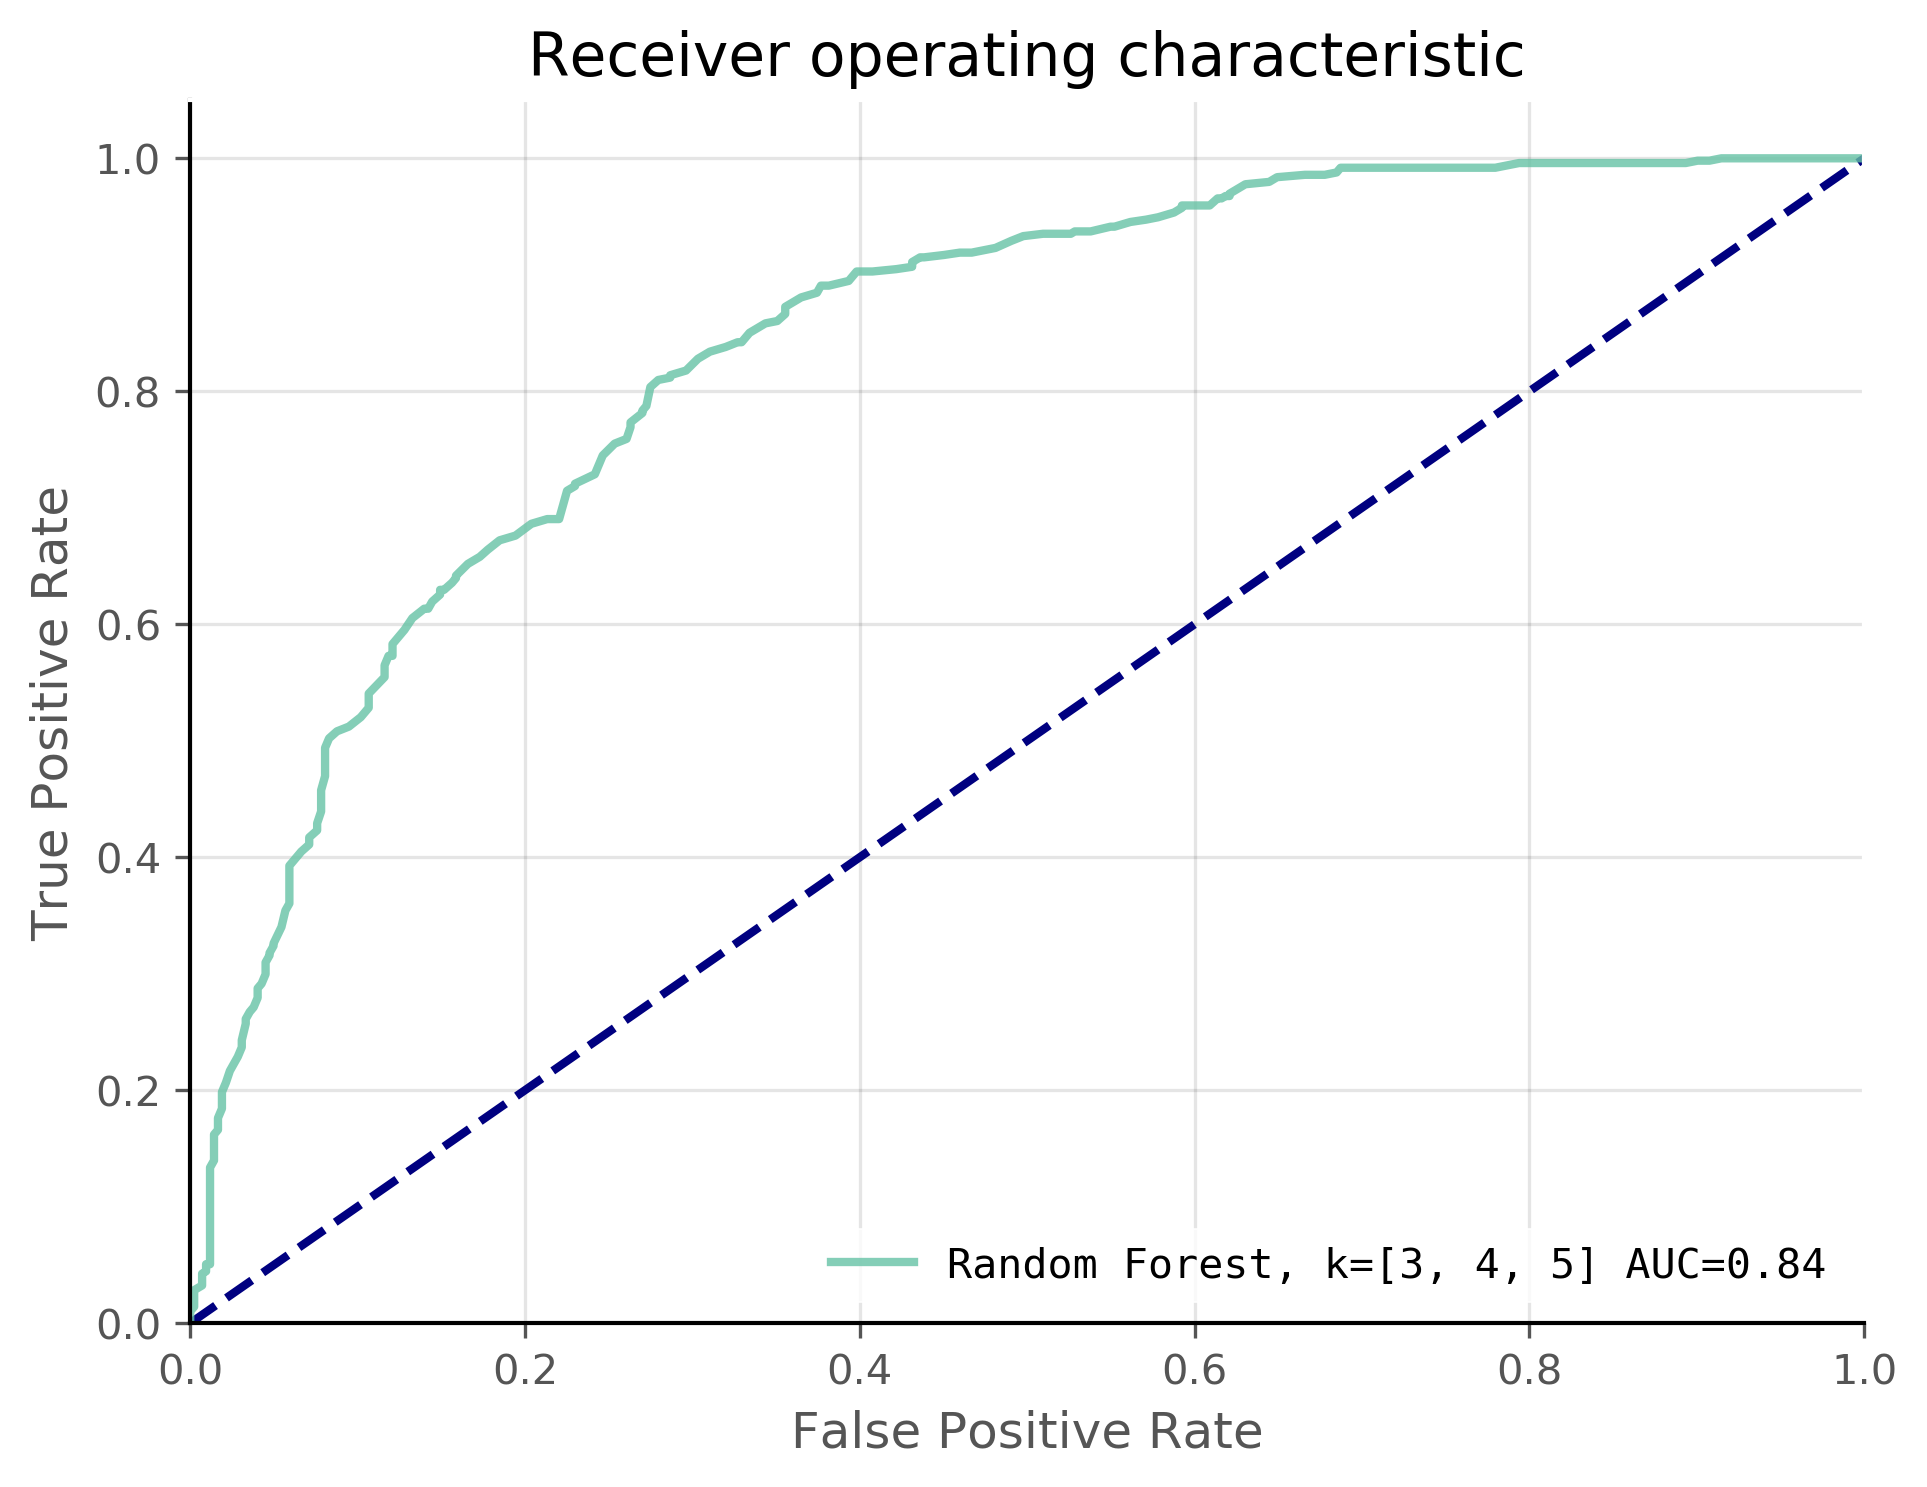

In [25]:
print("Accuracy: ", optimal_kmer_rf.accuracy)
print("Recall: ", optimal_kmer_rf.recall)
print("F1: ", optimal_kmer_rf.f1)
print("AUROC: ", optimal_kmer_rf.auroc)
print("AUPRC: ", optimal_kmer_rf.auprc)
plotting_utils.plot_auroc({"Random Forest, k=[3, 4, 5]": optimal_kmer_rf})

## Investigating effect of truncating to different sized tail sequences

For convolutional neural networks, we need to feed in a fixed size sequence. Our current strategy for this is to feed in the 3' 1000 base pairs, truncating and padding as necessary. We then perform the same classification as above in order to see if this truncation operation loses critical information.

In [26]:
importlib.reload(data_loader)  # For dev
optimal_kmer_trim_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], fixed_seq_len=-1000))
optimal_kmer_trim_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], fixed_seq_len=-1000))
print("Shape of trimmed kmer training input:   {}".format(optimal_kmer_trim_train_data[0].shape))
print("Shape of trimmed kmer validation input: {}".format(optimal_kmer_trim_valid_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of trimmed kmer training input:   (7323, 1344)
Shape of trimmed kmer validation input: (916, 1344)


In [27]:
optimal_kmer_trim_model, optimal_kmer_trim_rf = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), optimal_kmer_trim_train_data, optimal_kmer_trim_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.7840316019724849
AUPRC:	 0.7910178863701074
Acc:	 0.7074235807860262
Rec:	 0.7753036437246964
Prec:	 0.7092592592592593
F1:	 0.7408123791102516


Accuracy:  0.7074235807860262
Recall:  0.7753036437246964
F1:  0.7408123791102516
AUROC:  0.7840316019724849
AUPRC:  0.7910178863701074


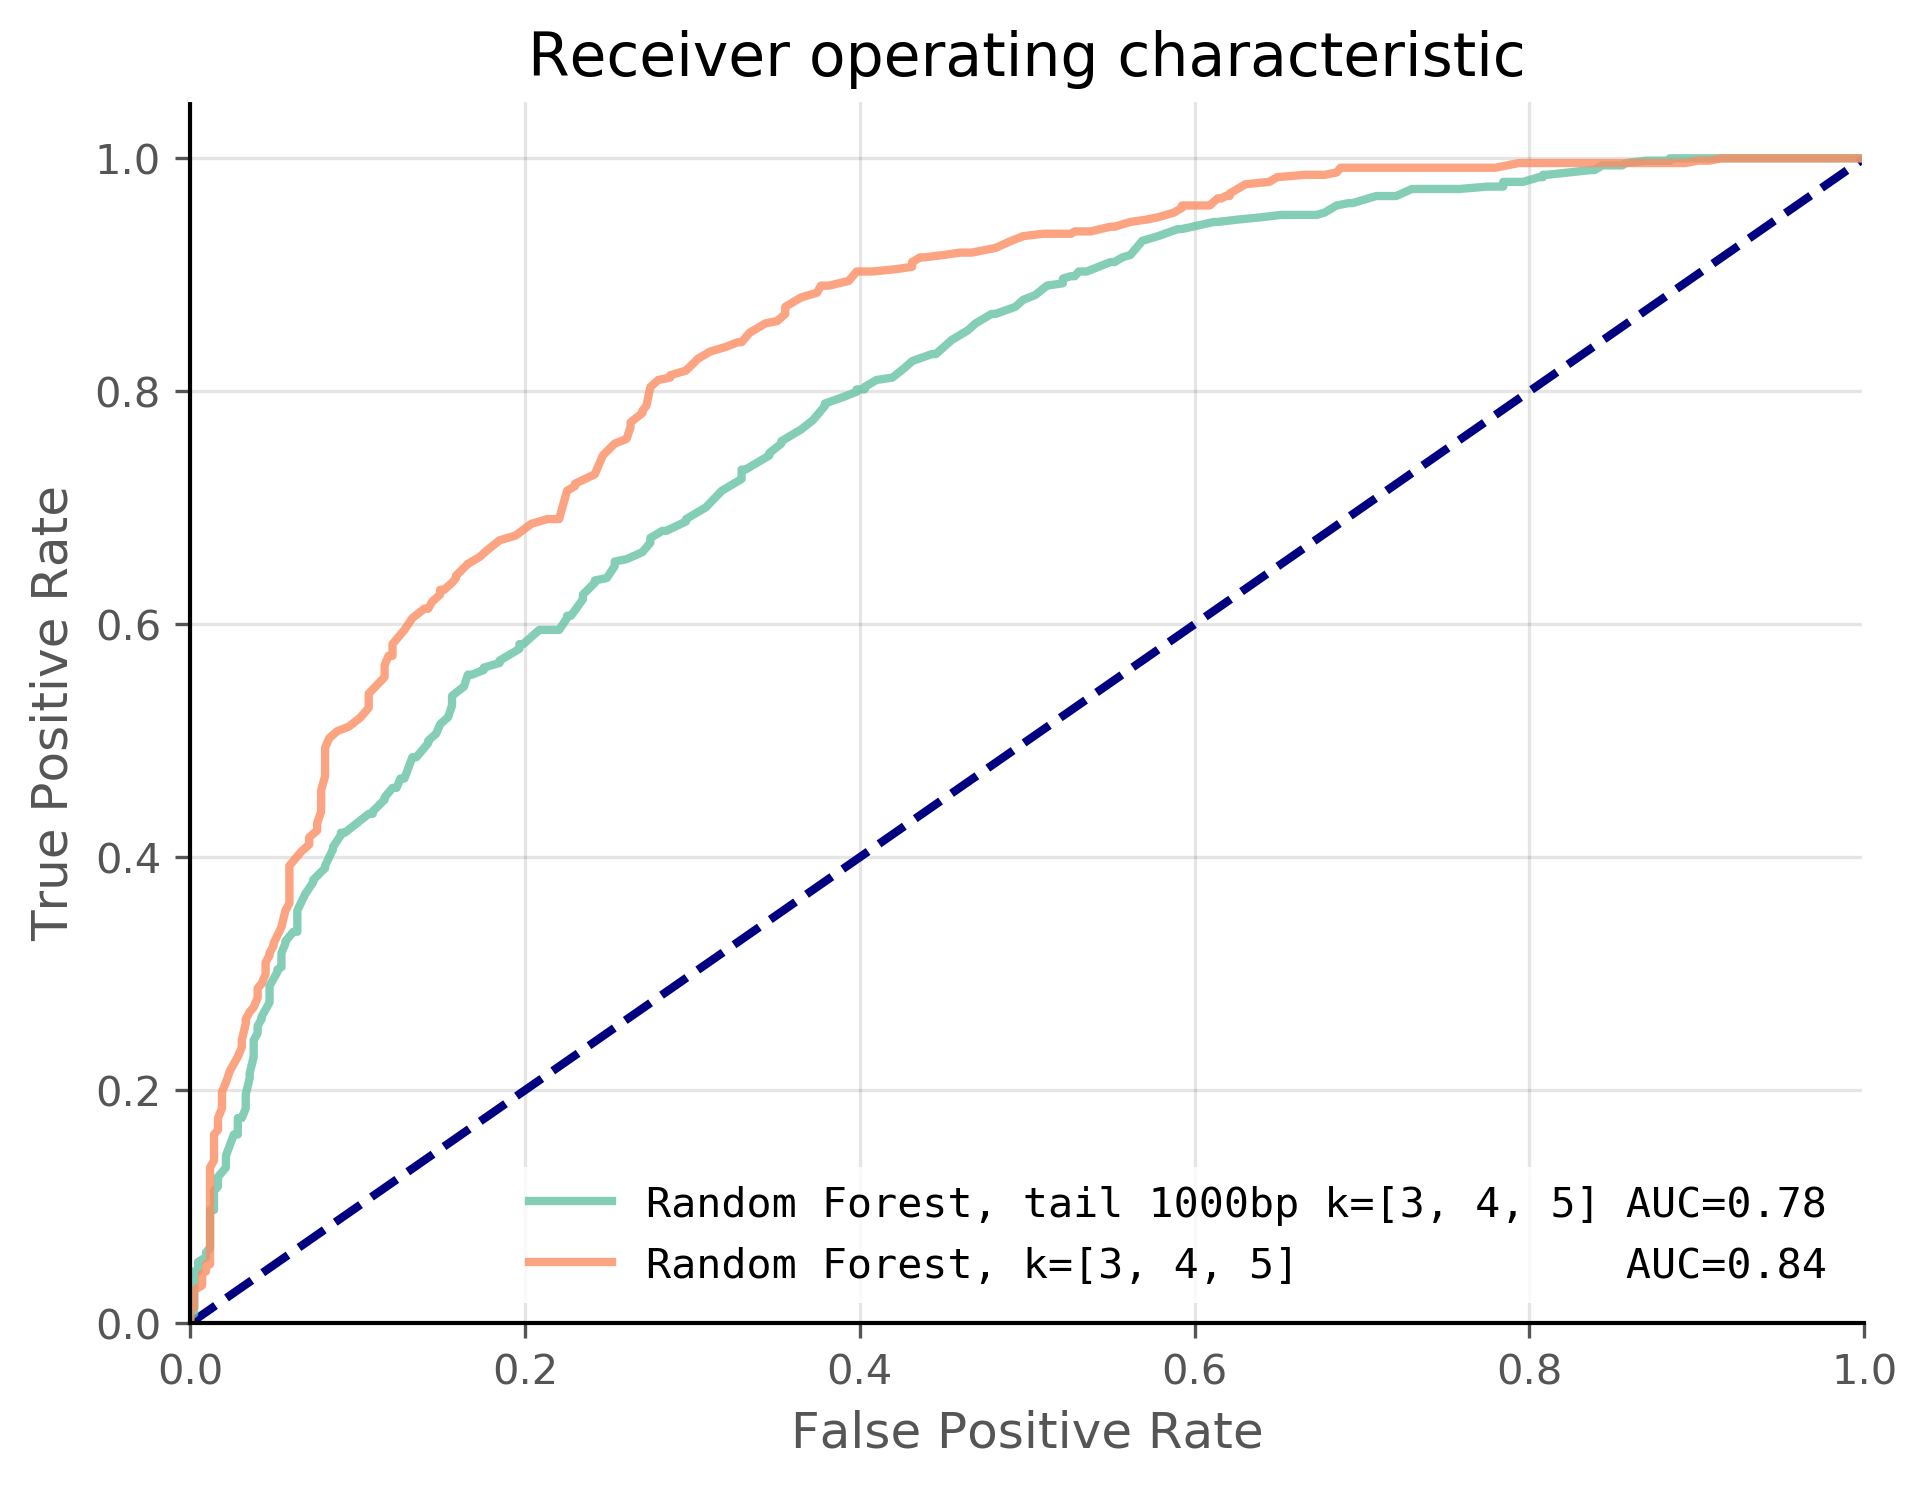

In [28]:
print("Accuracy: ", optimal_kmer_trim_rf.accuracy)
print("Recall: ", optimal_kmer_trim_rf.recall)
print("F1: ", optimal_kmer_trim_rf.f1)
print("AUROC: ", optimal_kmer_trim_rf.auroc)
print("AUPRC: ", optimal_kmer_trim_rf.auprc)
plotting_utils.plot_auroc({"Random Forest, tail 1000bp k=[3, 4, 5]": optimal_kmer_trim_rf, "Random Forest, k=[3, 4, 5]": optimal_kmer_rf})

In [29]:
importlib.reload(data_loader)  # For dev
optimal_kmer_trim_head_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], fixed_seq_len=1000))
optimal_kmer_trim_head_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], fixed_seq_len=1000))
print("Shape of trimmed kmer training input:   {}".format(optimal_kmer_trim_head_train_data[0].shape))
print("Shape of trimmed kmer validation input: {}".format(optimal_kmer_trim_head_valid_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of trimmed kmer training input:   (7323, 1344)
Shape of trimmed kmer validation input: (916, 1344)


In [30]:
optimal_kmer_trim_head_model, optimal_kmer_trim_head_rf = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=8,
    class_weight="balanced",
), optimal_kmer_trim_head_train_data, optimal_kmer_trim_head_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.836910221232995
AUPRC:	 0.8250002188233883
Acc:	 0.7849344978165939
Rec:	 0.8562753036437247
Prec:	 0.7704918032786885
F1:	 0.8111217641418984


Accuracy:  0.7074235807860262
Recall:  0.7753036437246964
F1:  0.7408123791102516
AUROC:  0.7840316019724849
AUPRC:  0.7910178863701074


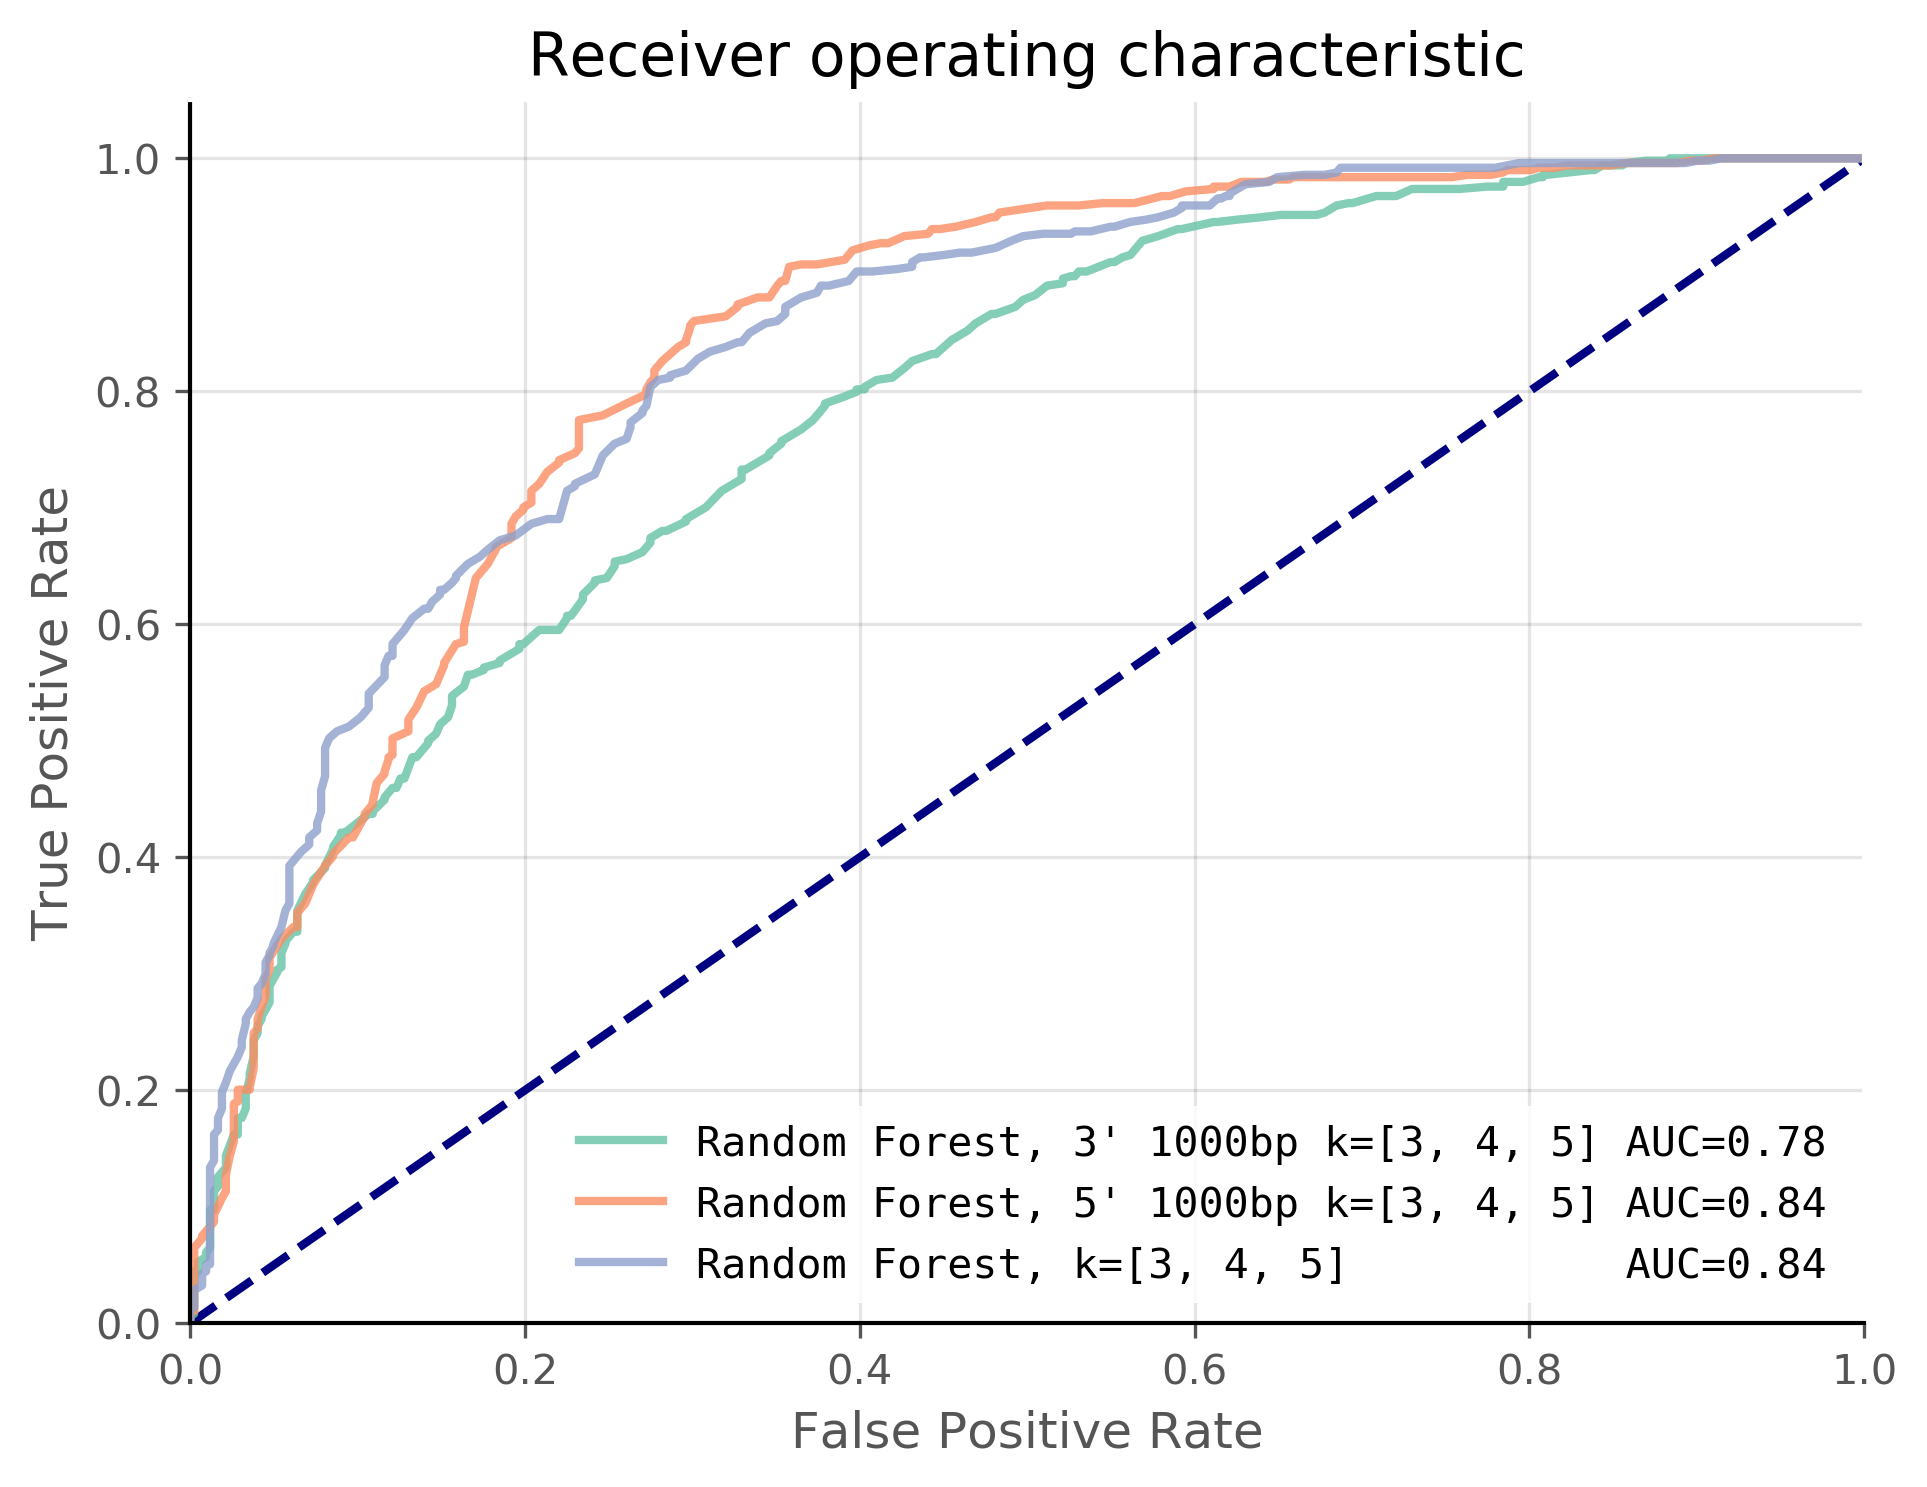

In [31]:
print("Accuracy: ", optimal_kmer_trim_rf.accuracy)
print("Recall: ", optimal_kmer_trim_rf.recall)
print("F1: ", optimal_kmer_trim_rf.f1)
print("AUROC: ", optimal_kmer_trim_rf.auroc)
print("AUPRC: ", optimal_kmer_trim_rf.auprc)
plotting_utils.plot_auroc({
    "Random Forest, 3' 1000bp k=[3, 4, 5]": optimal_kmer_trim_rf,
    "Random Forest, 5' 1000bp k=[3, 4, 5]": optimal_kmer_trim_head_rf,
    "Random Forest, k=[3, 4, 5]": optimal_kmer_rf
})

Compared to featurizing the entire sequence, we find that featurizing just the last 1000 base pairs results in a drop in performance in both AUROC and AUPRC.

## Investigating a chunk-by-chunk featurization

Up to this point, we've been featurizing the entire sequence at once. However, we also have information that tells us the 5' utr, cds, and the 3' utr of the sequence. We now look at whether featurizing each of these regions separately improves performance. The rationale here is that the UTR regions might contain a strong signal, one that might be drowned out when kmer-ized with the the CDS (which may contain less information)

In [32]:
importlib.reload(data_loader)  # For dev
parted_kmer_valid_dataset = data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], seq_by_parts=True)
parted_kmer_valid_data = data_loader.load_data_as_np(parted_kmer_valid_dataset)
parted_kmer_train_dataset = data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], seq_by_parts=True)
parted_kmer_train_data = data_loader.load_data_as_np(parted_kmer_train_dataset)
parted_kmer_test_dataset = data_loader.NLSvNESDataset('test', kmer_sizes=[3, 4, 5], seq_by_parts=True)
parted_kmer_test_data = data_loader.load_data_as_np(parted_kmer_test_dataset)
print("Shape of trimmed kmer training input:   {}".format(parted_kmer_train_data[0].shape))
print("Shape of trimmed kmer validation input: {}".format(parted_kmer_valid_data[0].shape))
print("Shape of trimmed kmer test input: {}".format(parted_kmer_test_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene


INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in test: 0.5131004366812227
INFO:root:597	0.6517467248908297	Protein coding - containing ORF
INFO:root:70	0.07641921397379912	Antisense
INFO:root:63	0.06877729257641921	Alt spliced transcript with intronic sequence
INFO:root:51	0.055676855895196505	Processed transcript without ORF
INFO:root:49	0.05349344978165939	lincRNA
INFO:root:35	0.03820960698689956	Nonsense mediated decay
INFO:root:13	0.014192139737991267	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:12	0.013100436681222707	Processed pseudogene
INFO:root:4	0.004366812227074236	Pseudogene, partially expressed
INFO:root:4	0.004366812227074236	Sense overlapping
INFO:root:3	0.0032751091703056767	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Non stop decay (poly A features without prior stop codon in CDS) subject to degradation
INFO:root:1	0.001091703056768559	To be experi


Shape of trimmed kmer training input:   (7323, 4032)
Shape of trimmed kmer validation input: (916, 4032)
Shape of trimmed kmer test input: (916, 4032)


In [33]:
rf_n_estimators = [100, 150, 200, 250, 300]
rf_criterion = ["gini", "entropy"]
rf_max_depth = [25, 50, 100, 200]
rf_min_samples_leaf = [0.001, 0.01, 0.1]
rf_max_features = ["sqrt", "log2"]
rf_class_weight = ['balanced', None]

rf_param_combos = list(itertools.product(
    rf_n_estimators,
    rf_criterion,
    rf_max_depth,
    rf_min_samples_leaf,
    rf_max_features,
    rf_class_weight,
))

param_combos_overall_perf = []
param_combos_models = []
importlib.reload(model_utils)
for n_est, crit, depth, min_samp, max_feat, weight in tqdm.tqdm_notebook(rf_param_combos):
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 32,
        "random_state": 39282,
    }

    parted_kmer_model, parted_kmer_rf = single_train(
        RandomForestClassifier(**rf_param_dict),
        parted_kmer_train_data,
        parted_kmer_valid_data,
        verbose=False,
    )
    param_combos_models.append(parted_kmer_model)
    param_combos_overall_perf.append(parted_kmer_rf)

In [34]:
param_combos_aurocs = [p.auroc for p in param_combos_overall_perf]
param_combos_auprcs = [p.auprc for p in param_combos_overall_perf]
param_combos_best_idx = np.argmax(param_combos_aurocs)
print(param_combos_aurocs[param_combos_best_idx], param_combos_auprcs[param_combos_best_idx])
parted_kmer_model = param_combos_models[param_combos_best_idx]
parted_kmer_rf = param_combos_overall_perf[param_combos_best_idx]

0.879818485331082 0.8840410656306381


In [35]:
rf_param_combos[param_combos_best_idx]

(150, 'gini', 50, 0.001, 'sqrt', None)

Best parameter combo: `(150, 'gini', 50, 0.001, 'sqrt', None)`

In [36]:
# Save the random forest model
# https://scikit-learn.org/stable/modules/model_persistence.html
with open("nes_nls_rf_model.sklearn", 'wb') as sink:
    pickle.dump(parted_kmer_model, sink)

Accuracy:  0.8067685589519651
Recall:  0.8846153846153846
F1:  0.8315889628924832
AUROC:  0.879818485331082
AUPRC:  0.8840410656306381


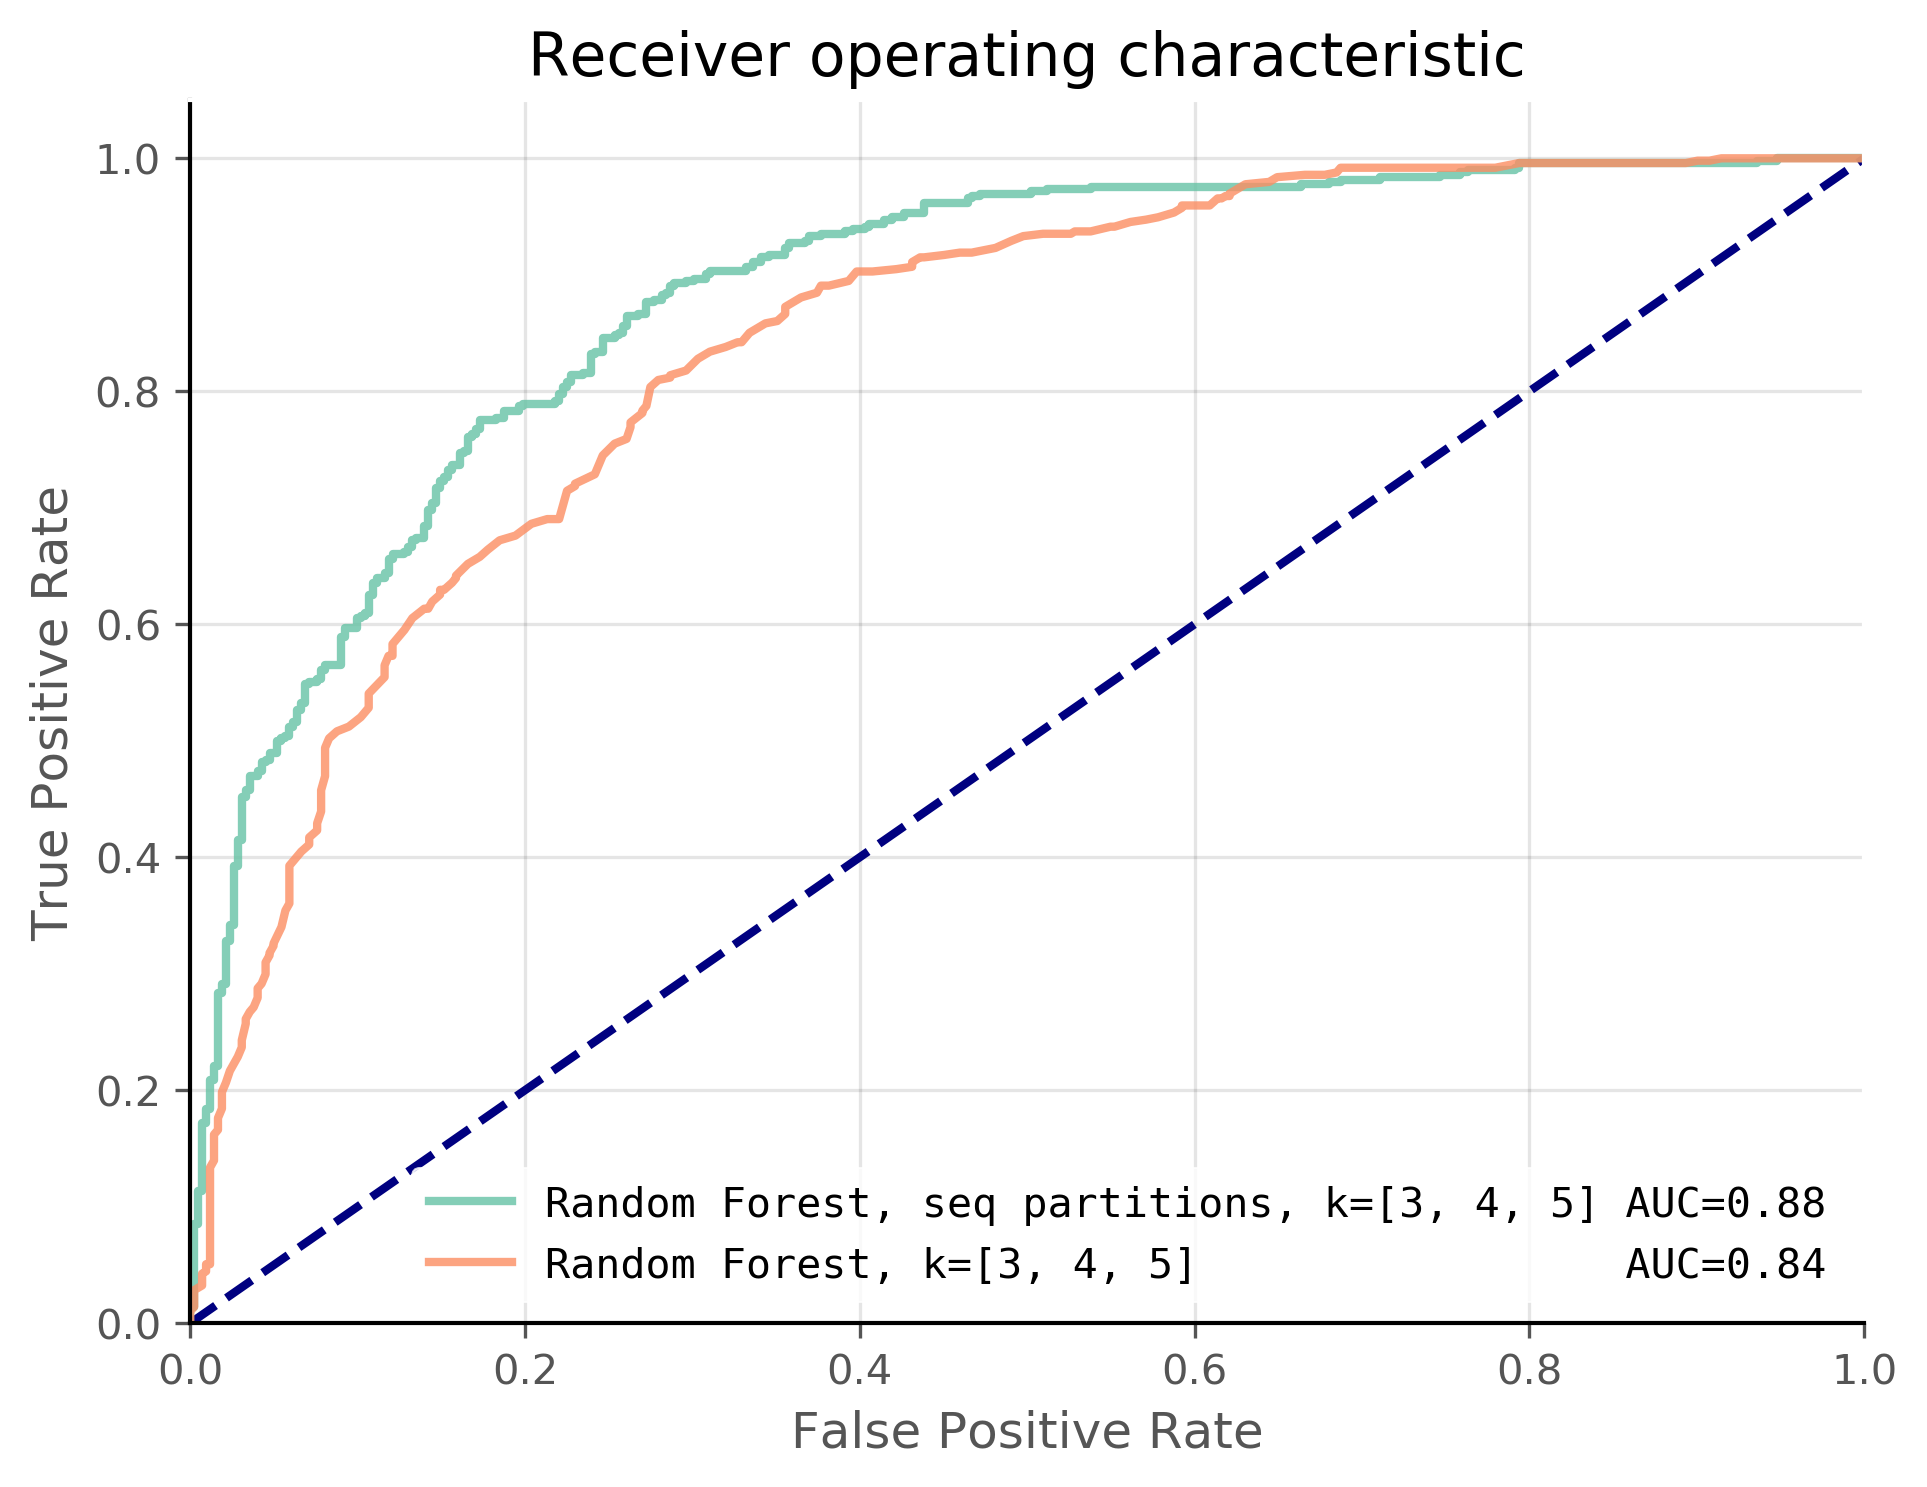

In [37]:
# Validation set results
print("Accuracy: ", parted_kmer_rf.accuracy)
print("Recall: ", parted_kmer_rf.recall)
print("F1: ", parted_kmer_rf.f1)
print("AUROC: ", parted_kmer_rf.auroc)
print("AUPRC: ", parted_kmer_rf.auprc)
importlib.reload(plotting_utils)
plotting_utils.plot_auroc({"Random Forest, seq partitions, k=[3, 4, 5]": parted_kmer_rf, "Random Forest, k=[3, 4, 5]": optimal_kmer_rf})

In [66]:
parted_kmer_test_perf = model_utils.generate_model_perf(
    parted_kmer_test_data[1],  # Array of 0/1
    parted_kmer_model.predict_proba(parted_kmer_test_data[0])[:, 1].flatten(),
    multiclass=False,
)
parted_kmer_test_perf.auroc, parted_kmer_test_perf.auprc

(0.854617879973285, 0.8209684482776726)

Partitioning the sequence into segments, that are then independently featurized does indeed appear to significantly improve performance, bumping AUROC from 0.8376 to 0.8747, AUPRC from 0.8331 to 0.8789, and F1 from 0.7741 to 0.8336.

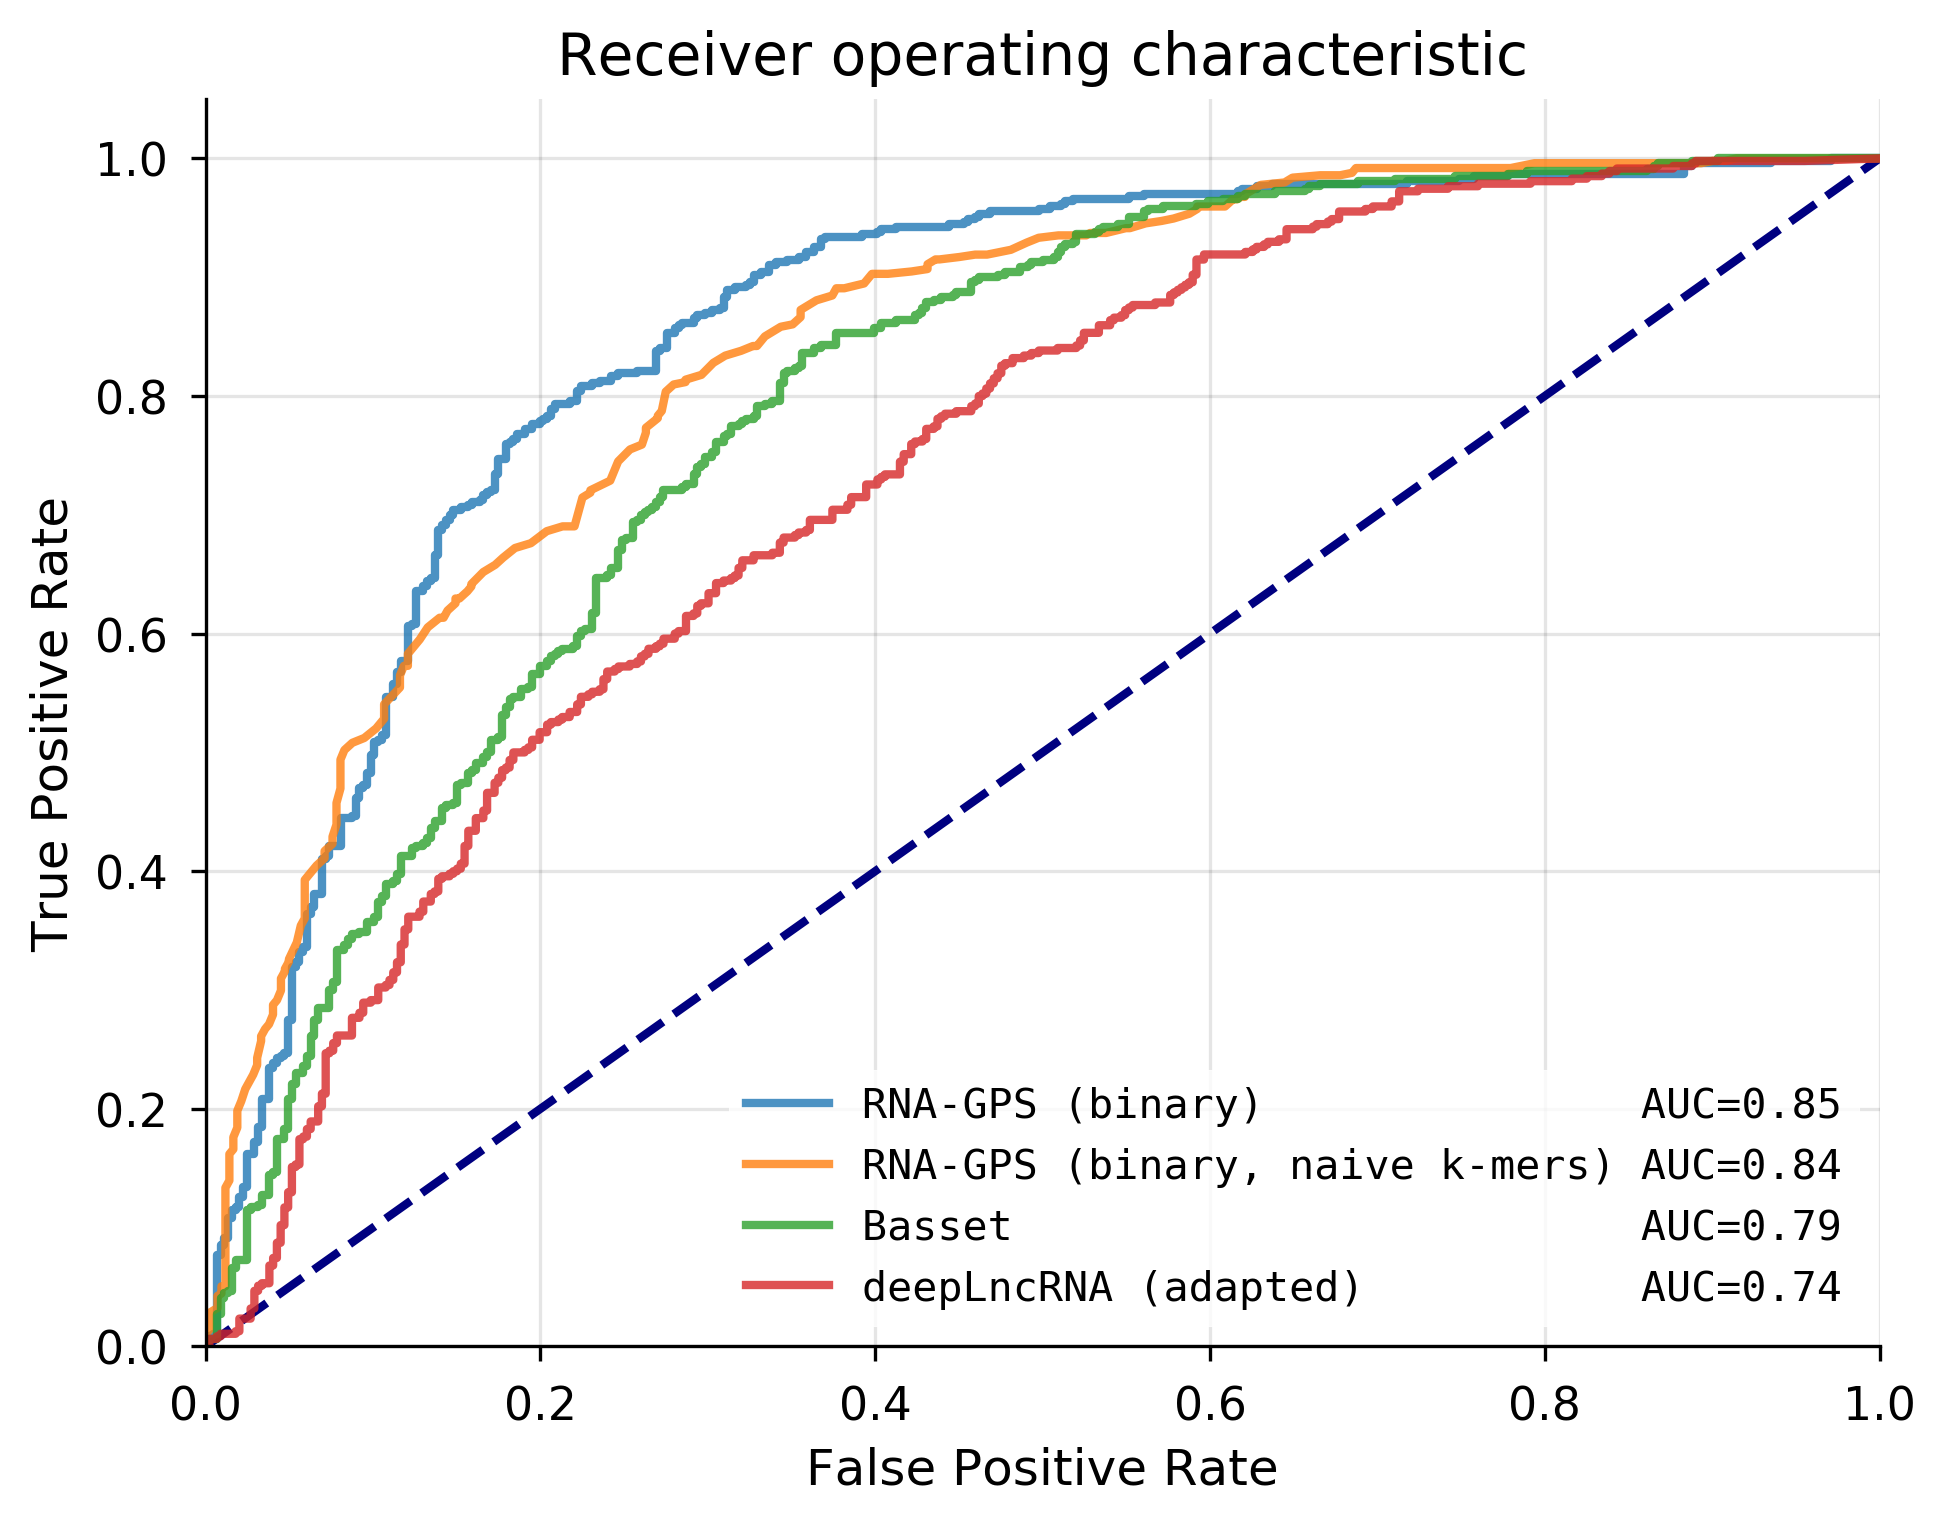

In [118]:
#Plot with the curves from neural nets
#Borrow a reduced model perf definition

ModelPerf = collections.namedtuple('ModelPerf', ['auroc', 'auroc_curve', 'auprc', 'accuracy', 'recall', 'precision', 'f1'])
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {
        "RNA-GPS (binary)": parted_kmer_test_perf,
        "RNA-GPS (binary, naive k-mers)": optimal_kmer_rf,
        "Basset": pickle.load(open('vanilla_basset.test.perf', 'rb')),
        "deepLncRNA (adapted)": pickle.load(open('densenet.test.perf', 'rb')),
    },
    cmap="tab10",
    bg_color='white',
    grid=True,
    fname=os.path.join(PLOT_DIR, "nuc_cyto_auroc.pdf"),
)
from model_utils import ModelPerf  # Restore original model perf obj

In [39]:
# Investigate lncRNA specific performance
importlib.reload(data_loader)
lncrna_only_test_dataset = data_loader.NLSvNESDataset('test', kmer_sizes=[3, 4, 5], seq_by_parts=True, trans_types=['lincRNA'])
lncrna_only_test_data = data_loader.load_data_as_np(lncrna_only_test_dataset)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Retained 49 transcript matching types ['lincRNA']
INFO:root:Proportion of positives in test: 0.061224489795918366
INFO:root:49	1.0	lincRNA


In [40]:
lncrna_only_test_preds = parted_kmer_model.predict_proba(lncrna_only_test_data[0])
print(metrics.roc_auc_score(lncrna_only_test_data[1], lncrna_only_test_preds[:, 1]))

0.32608695652173914


In [41]:
# Investigate coding specific performance
importlib.reload(data_loader)
coding_only_test_dataset = data_loader.NLSvNESDataset('test', kmer_sizes=[3, 4, 5], seq_by_parts=True, trans_types=['Protein coding - containing ORF'])
coding_only_test_data = data_loader.load_data_as_np(coding_only_test_dataset)

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Retained 597 transcript matching types ['Protein coding - containing ORF']
INFO:root:Proportion of positives in test: 0.7068676716917923
INFO:root:597	1.0	Protein coding - containing ORF


In [42]:
coding_only_test_preds = parted_kmer_model.predict_proba(coding_only_test_data[0])
print(metrics.roc_auc_score(coding_only_test_data[1], coding_only_test_preds[:, 1]))

0.732024373730535


## Heatmap

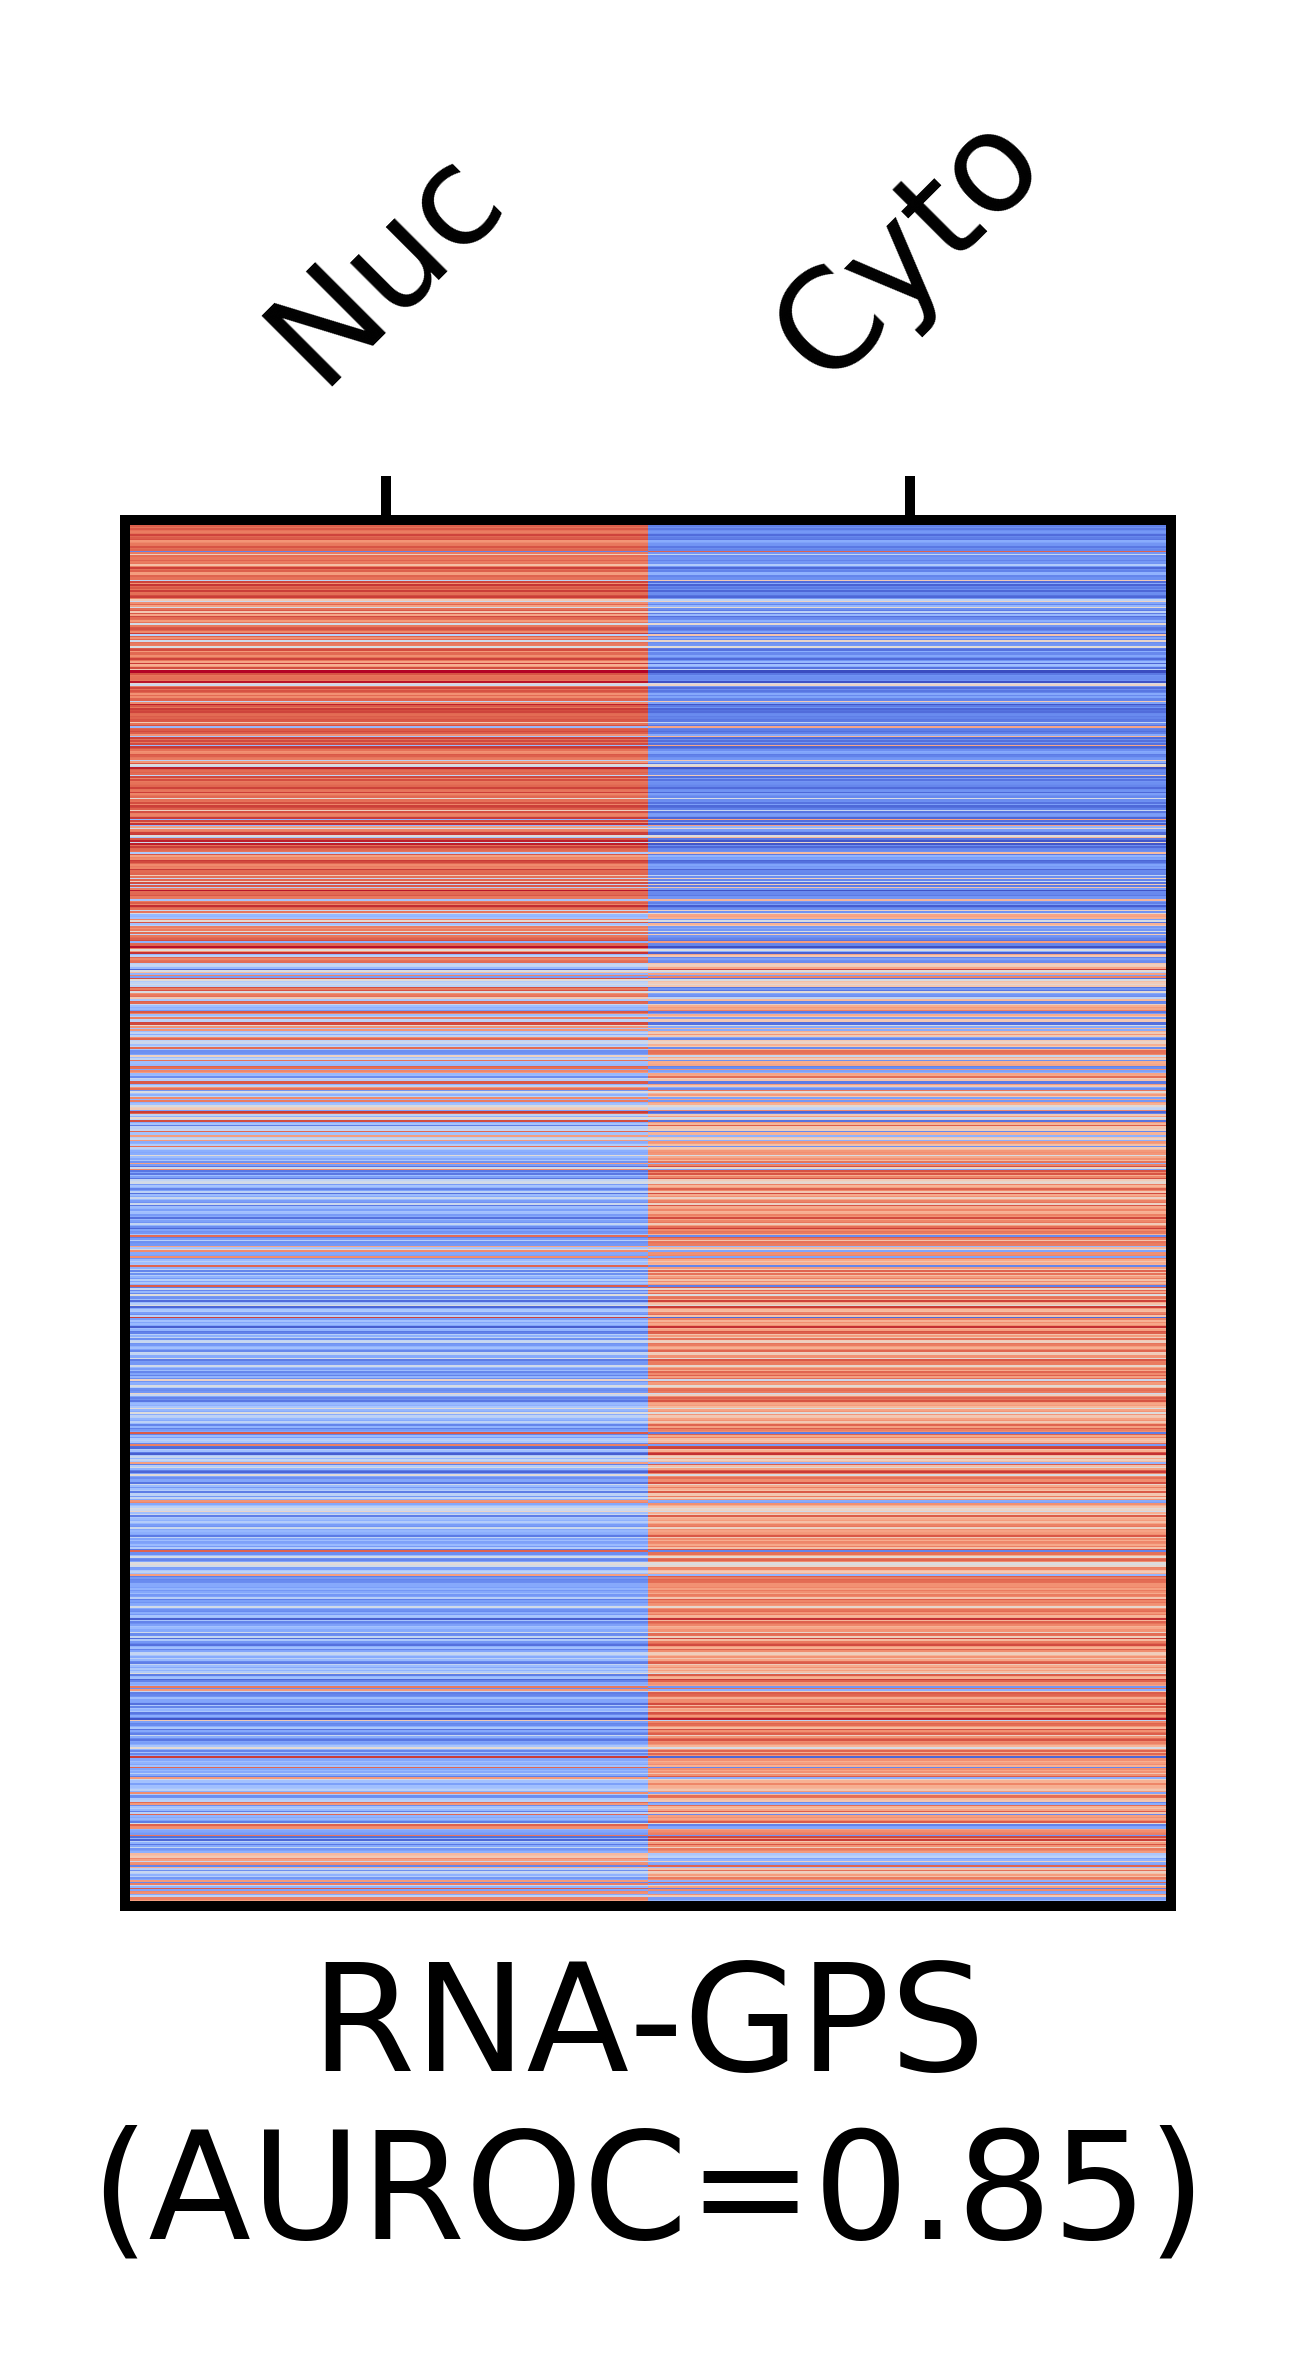

In [115]:
# Xist (ENSG00000229807) has a log2fc of -3
# Xist is NUCLEAR
# Therefore negative is nuclear
# Negatives are made 0 in labels, and positives are made 1
# Therefore 0 is nuclear, and 1 is cytoplasmic
# print(valid_data_sorted[1])
# The labels are sorted so 0 are first

parted_kmer_valid_log2fc = parted_kmer_valid_dataset.deseq_table_subsetted['log2FoldChange']
# idx_valid_label_sort = np.argsort(parted_kmer_valid_data[1])
idx_valid_label_sort = np.argsort(parted_kmer_valid_log2fc)
valid_data_sorted = (parted_kmer_valid_data[0][idx_valid_label_sort, :], parted_kmer_valid_data[1][idx_valid_label_sort])
valid_data_sorted_preds = parted_kmer_model.predict_proba(valid_data_sorted[0])

fig, ax = plt.subplots(dpi=900, figsize=(1.5, 2))
cax = ax.matshow(valid_data_sorted_preds, aspect='auto', cmap=plt.cm.coolwarm)
ax.set_xticklabels(['', 'Nuc', 'Cyto'], rotation=45)
ax.set_yticklabels([])
ax.tick_params(bottom=False, left=False)
ax.set(
    xlabel=f"RNA-GPS\n(AUROC={parted_kmer_test_perf.auroc:.2f})"
)
ax.grid(False)
# fig.colorbar(cax)
fig.savefig(os.path.join(PLOT_DIR, "nuc_cyto_heatmap_rnagps.pdf"), bbox_inches='tight')
fig.show()

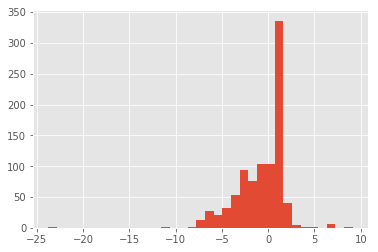

In [44]:
fig, ax = plt.subplots()
ax.hist(
    parted_kmer_valid_dataset.deseq_table_subsetted['log2FoldChange'],
    bins=35,
)
fig.show()

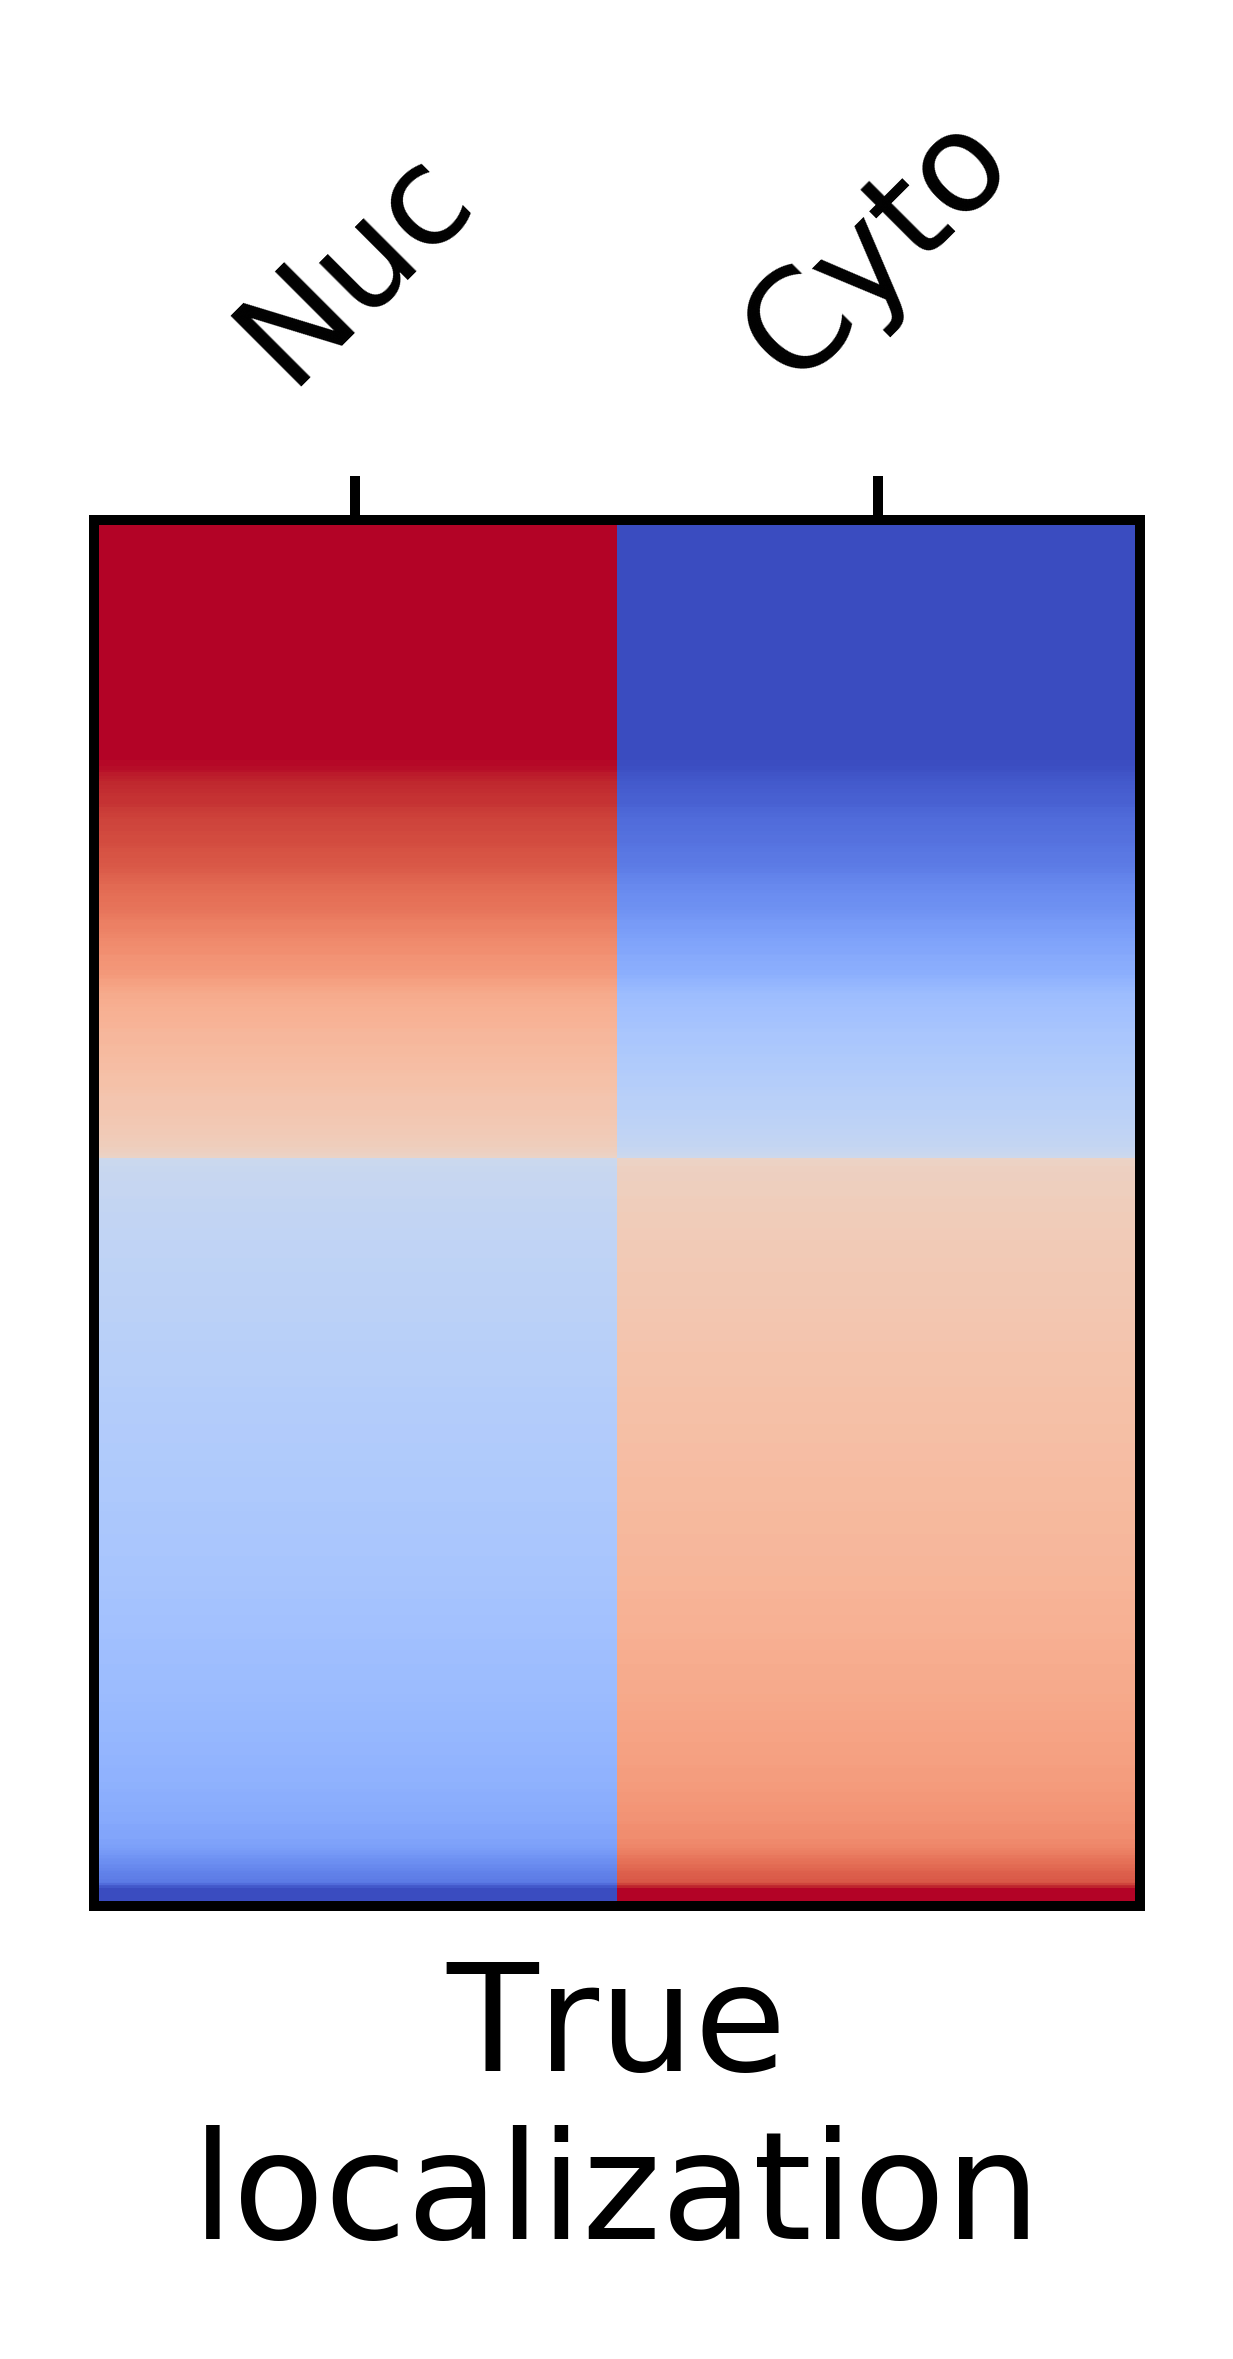

In [116]:
# True labels heatmap
parted_kmer_valid_log2fc = parted_kmer_valid_dataset.deseq_table_subsetted['log2FoldChange']
parted_kmer_valid_log2fc = np.clip(parted_kmer_valid_log2fc, -3, 3)
parted_kmer_valid_log2fc_norm = (parted_kmer_valid_log2fc - min(parted_kmer_valid_log2fc)) / (max(parted_kmer_valid_log2fc) - min(parted_kmer_valid_log2fc))
parted_kmer_valid_log2fc_norm_sorted = parted_kmer_valid_log2fc_norm[idx_valid_label_sort]

fig, ax = plt.subplots(dpi=900, figsize=(1.5, 2))
# cax = ax.matshow(np.vstack([ 1.0 - valid_data_sorted[1], valid_data_sorted[1]]).T, aspect='auto', cmap=plt.cm.coolwarm)
cax = ax.matshow(np.vstack([1.0 - parted_kmer_valid_log2fc_norm_sorted, parted_kmer_valid_log2fc_norm_sorted]).T, aspect='auto', cmap=plt.cm.coolwarm)
ax.set_xticklabels(['', 'Nuc', 'Cyto'], rotation=45)
ax.set_yticklabels([])
ax.tick_params(bottom=False, left=False)
ax.set(
    xlabel="True\nlocalization"
)
ax.grid(False)
# fig.colorbar(cax)
fig.savefig(os.path.join(PLOT_DIR, "nuc_cyto_heatmap_truth.pdf"), bbox_inches='tight')
fig.show()

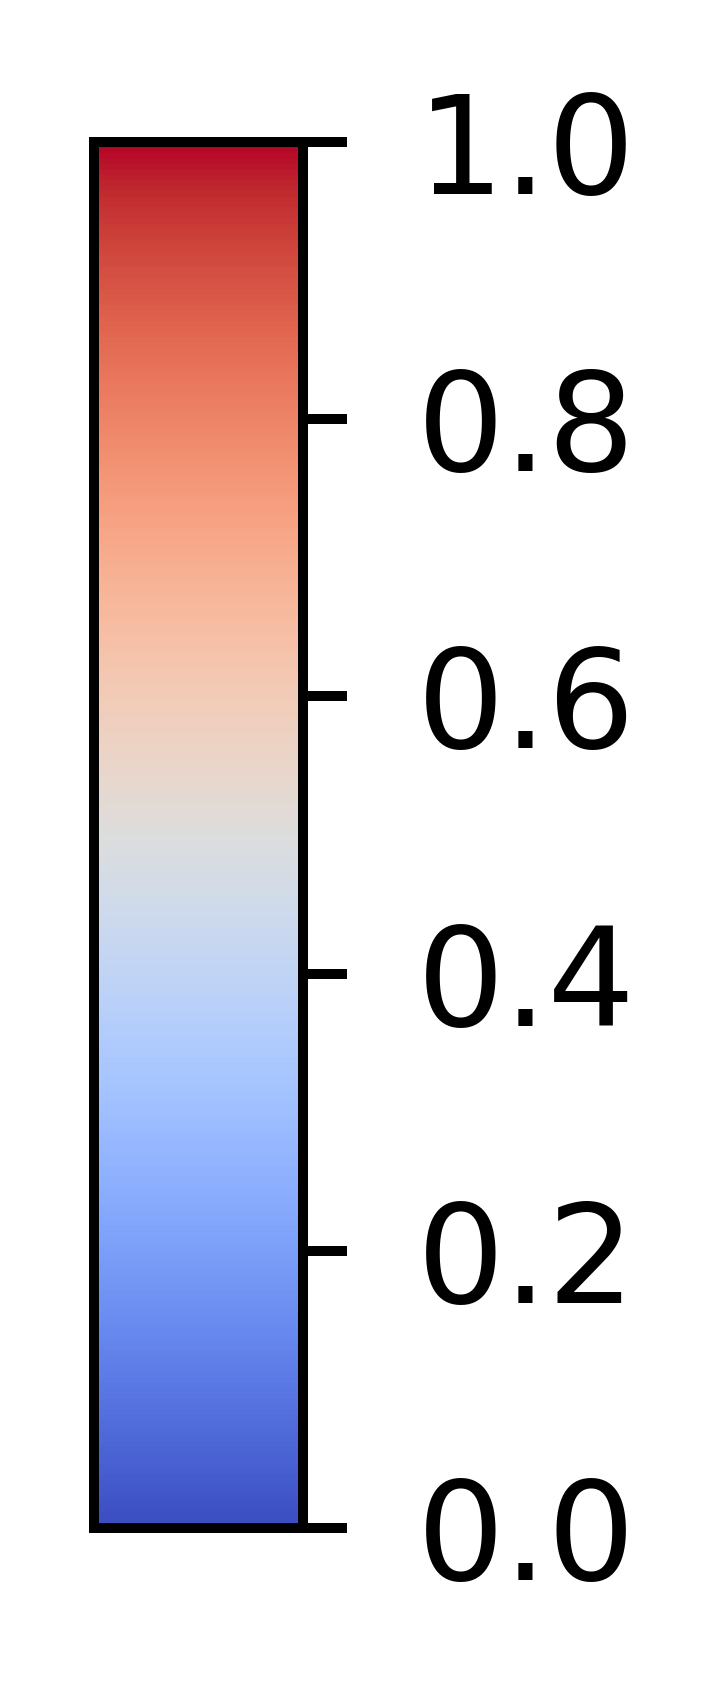

In [117]:
# colorbar
# https://matplotlib.org/3.1.0/tutorials/colors/colorbar_only.html
fig, ax = plt.subplots(dpi=900, figsize=(0.3, 2))
cb = mpl.colorbar.ColorbarBase(
    ax,
    cmap=plt.cm.coolwarm,
    norm=mpl.colors.Normalize(vmin=0.0, vmax=1.0),
    orientation='vertical',
)
fig.savefig(os.path.join(PLOT_DIR, "nuc_cyto_heatmap_legend.pdf"), bbox_inches='tight')

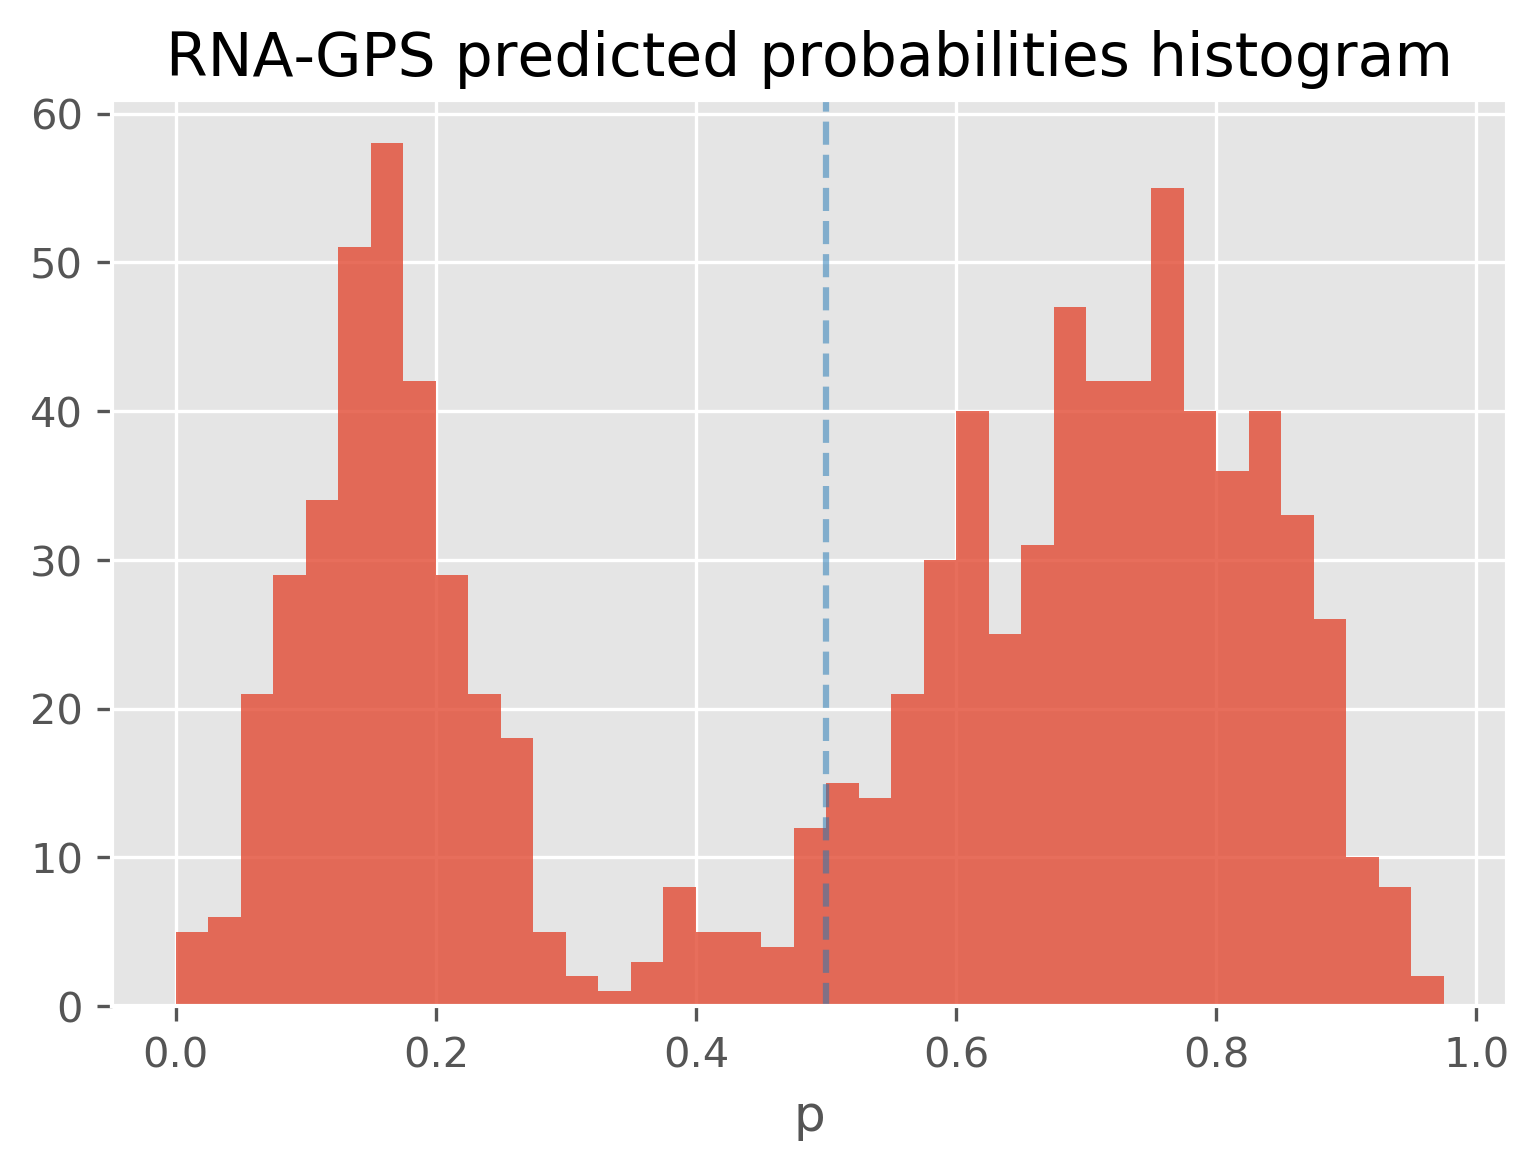

In [48]:
fig, ax = plt.subplots(dpi=300)
ax.hist(valid_data_sorted_preds[:, 1].flatten(), bins=np.arange(0.0, 1.0, 0.025), alpha=0.8)
ax.set(
    title='RNA-GPS predicted probabilities histogram',
    xlabel='p',
)
ax.axvline(0.5, color='tab:blue', alpha=0.5, linestyle='--')
ax.grid(True)
fig.show()

Since partitioning the sequence into segments might better preserve information, let's try trimming the sequence to a fixed length again.

In [49]:
importlib.reload(data_loader)  # For dev
importlib.reload(tqdm)

parted_kmer_trim_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], fixed_seq_len=-500, seq_by_parts=True))
parted_kmer_trim_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], fixed_seq_len=-500, seq_by_parts=True))
print("Shape of trimmed kmer training input:   {}".format(parted_kmer_trim_train_data[0].shape))
print("Shape of trimmed kmer validation input: {}".format(parted_kmer_trim_valid_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of trimmed kmer training input:   (7323, 4032)
Shape of trimmed kmer validation input: (916, 4032)


In [50]:
parted_kmer_trim_model, parted_kmer_trim_rf = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=16,
    class_weight="balanced",
), parted_kmer_trim_train_data, parted_kmer_trim_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.8682699503041235
AUPRC:	 0.8690922992304262
Acc:	 0.8045851528384279
Rec:	 0.8947368421052632
Prec:	 0.7768014059753954
F1:	 0.8316086547507054


In [51]:
importlib.reload(data_loader)  # For dev
parted_kmer_trim_short_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], fixed_seq_len=-300, seq_by_parts=True))
parted_kmer_trim_short_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], fixed_seq_len=-300, seq_by_parts=True))
print("Shape of trimmed kmer training input:   {}".format(parted_kmer_trim_short_train_data[0].shape))
print("Shape of trimmed kmer validation input: {}".format(parted_kmer_trim_short_valid_data[0].shape))

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in train: 0.5284719377304383
INFO:root:4718	0.644271473439847	Protein coding - containing ORF
INFO:root:567	0.07742728390004097	Processed transcript without ORF
INFO:root:541	0.07387682643725249	Antisense
INFO:root:458	0.06254267376758159	Alt spliced transcript with intronic sequence
INFO:root:402	0.05489553461696026	lincRNA
INFO:root:187	0.0255359825208248	Nonsense mediated decay
INFO:root:130	0.017752287313942374	Processed pseudogene
INFO:root:115	0.015703946470025945	Noncoding RNA predicted from Rfam and miRBase
INFO:root:89	0.012153489007237471	Sense intronic
INFO:root:40	0.005462242250443807	Pseudogene, unprocessed
INFO:root:28	0.003823569575310665	Pseudogene, partially expressed
INFO:root:28	0.003823569575310665	Sense overlapping
INFO:root:4	0.0005462242250443807	To be experimentally confirmed
INFO:root:4	0.0005462242250443807	Pseudogene
INFO:root:2	0.00027311211252219035	3prime overla

INFO:root:9155/34946 entries in table retained as significant
INFO:root:Proportion of positives in valid: 0.5393013100436681
INFO:root:573	0.6255458515283843	Protein coding - containing ORF
INFO:root:75	0.08187772925764192	Processed transcript without ORF
INFO:root:75	0.08187772925764192	Antisense
INFO:root:60	0.06550218340611354	Alt spliced transcript with intronic sequence
INFO:root:53	0.05786026200873363	lincRNA
INFO:root:24	0.026200873362445413	Nonsense mediated decay
INFO:root:20	0.021834061135371178	Processed pseudogene
INFO:root:14	0.015283842794759825	Sense intronic
INFO:root:13	0.014192139737991267	Noncoding RNA predicted from Rfam and miRBase
INFO:root:2	0.002183406113537118	Pseudogene, partially expressed
INFO:root:2	0.002183406113537118	Pseudogene
INFO:root:2	0.002183406113537118	Pseudogene, unprocessed
INFO:root:1	0.001091703056768559	Sense overlapping
INFO:root:1	0.001091703056768559	3prime overlapping ncRNA
INFO:root:1	0.001091703056768559	Polymorphic pseudogene



Shape of trimmed kmer training input:   (7323, 4032)
Shape of trimmed kmer validation input: (916, 4032)


In [52]:
parted_kmer_trim_short_model, parted_kmer_trim_short_rf = single_train(RandomForestClassifier(
    n_estimators=250,
    n_jobs=16,
    class_weight="balanced",
), parted_kmer_trim_short_train_data, parted_kmer_trim_short_valid_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
AUC:	 0.851667881881152
AUPRC:	 0.8504761977008163
Acc:	 0.8002183406113537
Rec:	 0.8927125506072875
Prec:	 0.7723292469352014
F1:	 0.8281690140845072


Accuracy:  0.8045851528384279
Recall:  0.8947368421052632
F1:  0.8316086547507054
AUROC:  0.8682699503041235
AUPRC:  0.8690922992304262


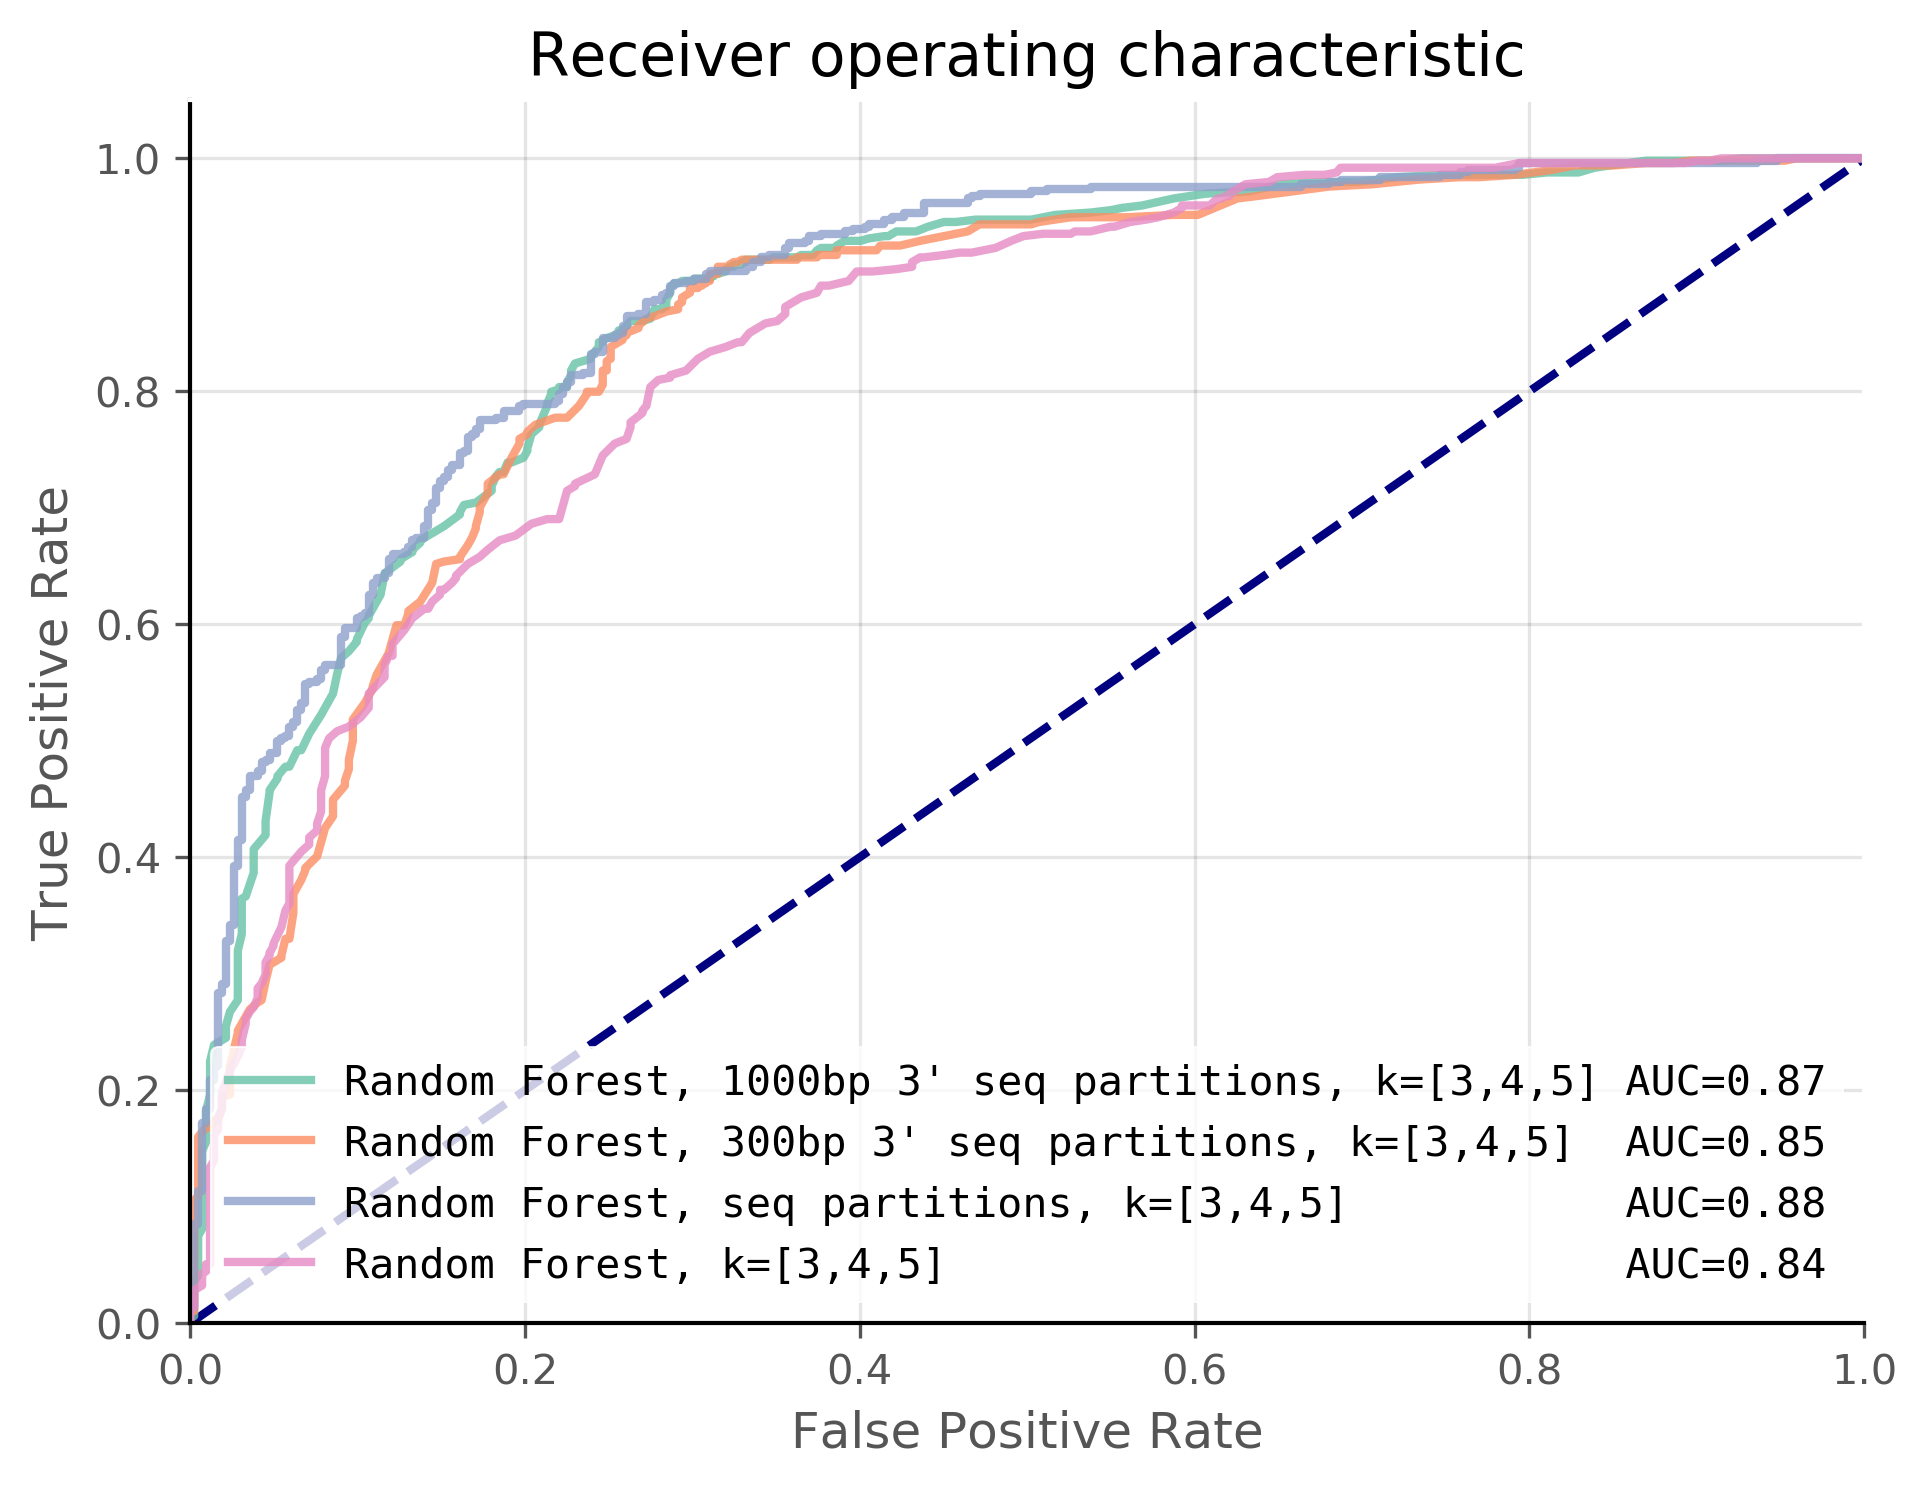

In [53]:
print("Accuracy: ", parted_kmer_trim_rf.accuracy)
print("Recall: ", parted_kmer_trim_rf.recall)
print("F1: ", parted_kmer_trim_rf.f1)
print("AUROC: ", parted_kmer_trim_rf.auroc)
print("AUPRC: ", parted_kmer_trim_rf.auprc)
importlib.reload(plotting_utils)
plotting_utils.plot_auroc({
    "Random Forest, 1000bp 3' seq partitions, k=[3,4,5]": parted_kmer_trim_rf,
    "Random Forest, 300bp 3' seq partitions, k=[3,4,5]": parted_kmer_trim_short_rf,
    "Random Forest, seq partitions, k=[3,4,5]": parted_kmer_rf,
    "Random Forest, k=[3,4,5]": optimal_kmer_rf},
)

We see that while trimming sequences indeed results in some drop in performance still, the drop is not nearly as drastic as the nearly 5-percentage point drop in AUROC that was previously observed.

## Inclusion of PWMs

Here we want to investigate whether including PWM features help with classification accuracy.

In [78]:
import pwm
parted_kmer_pwm_train_paths = [os.path.join(data_loader.DATA_DIR, "processed", suffix) for suffix in ["parted_kmer_pwm_train_x.txt", "parted_kmer_pwm_train_y.txt"]]
parted_kmer_pwm_valid_paths = [os.path.join(data_loader.DATA_DIR, "processed", suffix) for suffix in ["parted_kmer_pwm_valid_x.txt", "parted_kmer_pwm_valid_y.txt"]]
parted_kmer_pwm_test_paths = [os.path.join(data_loader.DATA_DIR, "processed", suffix) for suffix in ["parted_kmer_pwm_test_x.txt", "parted_kmer_pwm_test_y.txt"]]

if all([os.path.isfile(fname) for fname in parted_kmer_pwm_test_paths]):
    parted_kmer_pwm_test_data = tuple([np.loadtxt(fname) for fname in parted_kmer_pwm_test_paths])
else:
    parted_kmer_pwm_test_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('test', kmer_sizes=[3, 4, 5], seq_by_parts=True, pwms=pwm.load_all_ppm_in_dir()))
    for d, fname in zip(parted_kmer_pwm_test_data, parted_kmer_pwm_test_paths):
        np.savetxt(fname, d)

if all([os.path.isfile(fname) for fname in parted_kmer_pwm_valid_paths]):
    parted_kmer_pwm_valid_data = tuple([np.loadtxt(fname) for fname in parted_kmer_pwm_valid_paths])
else:
    parted_kmer_pwm_valid_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('valid', kmer_sizes=[3, 4, 5], seq_by_parts=True, pwms=data_loader.load_all_pwm_in_dir()))
    for d, fname in zip(parted_kmer_pwm_valid_data, parted_kmer_pwm_valid_paths):
        np.savetxt(fname, d)

if all([os.path.isfile(fname) for fname in parted_kmer_pwm_train_paths]):
    parted_kmer_pwm_train_data = tuple([np.loadtxt(fname) for fname in parted_kmer_pwm_train_paths])
else:
    parted_kmer_pwm_train_data = data_loader.load_data_as_np(data_loader.NLSvNESDataset('train', kmer_sizes=[3, 4, 5], seq_by_parts=True, pwms=data_loader.load_all_pwm_in_dir()))
    for d, fname in zip(parted_kmer_pwm_train_data, parted_kmer_pwm_train_paths):
        np.savetxt(fname, d)

In [79]:
print("Shape of kmer + pwm training input:   {}".format(parted_kmer_pwm_train_data[0].shape))
print("Shape of kmer + pwm validation input: {}".format(parted_kmer_pwm_valid_data[0].shape))
print("Shape of kmer + pwm testing input:    {}".format(parted_kmer_pwm_test_data[0].shape))

Shape of kmer + pwm training input:   (7323, 4225)
Shape of kmer + pwm validation input: (916, 4225)
Shape of kmer + pwm testing input:    (916, 4225)


In [67]:
importlib.reload(model_utils)
kmer_pwm_param_combos_overall_perf = []
kmer_pwm_param_combos_models = []

for n_est, crit, depth, min_samp, max_feat, weight in tqdm.tqdm_notebook(rf_param_combos):
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 32,
        "random_state": 39282,
    }

    pwm_kmer_model, pwm_kmer_rf = single_train(
        RandomForestClassifier(**rf_param_dict),
        parted_kmer_pwm_train_data,
        parted_kmer_pwm_valid_data,
        verbose=False,
    )
    kmer_pwm_param_combos_models.append(pwm_kmer_model)
    kmer_pwm_param_combos_overall_perf.append(pwm_kmer_rf)

In [72]:
pwm_kmer_aurocs = [p.auroc for p in kmer_pwm_param_combos_overall_perf]
pwm_kmer_auprcs = [p.auprc for p in kmer_pwm_param_combos_overall_perf]
pwm_kmer_best_idx = np.argmax(pwm_kmer_aurocs)
print(pwm_kmer_aurocs[pwm_kmer_best_idx], pwm_kmer_auprcs[pwm_kmer_best_idx])

parted_kmer_pwm_model = kmer_pwm_param_combos_models[pwm_kmer_best_idx]
parted_kmer_pwm_rf = kmer_pwm_param_combos_overall_perf[pwm_kmer_best_idx]

0.8829700481608689 0.887930118707147


Accuracy:  0.8067685589519651
Recall:  0.8785425101214575
F1:  0.830622009569378
AUROC:  0.8829700481608689
AUPRC:  0.887930118707147


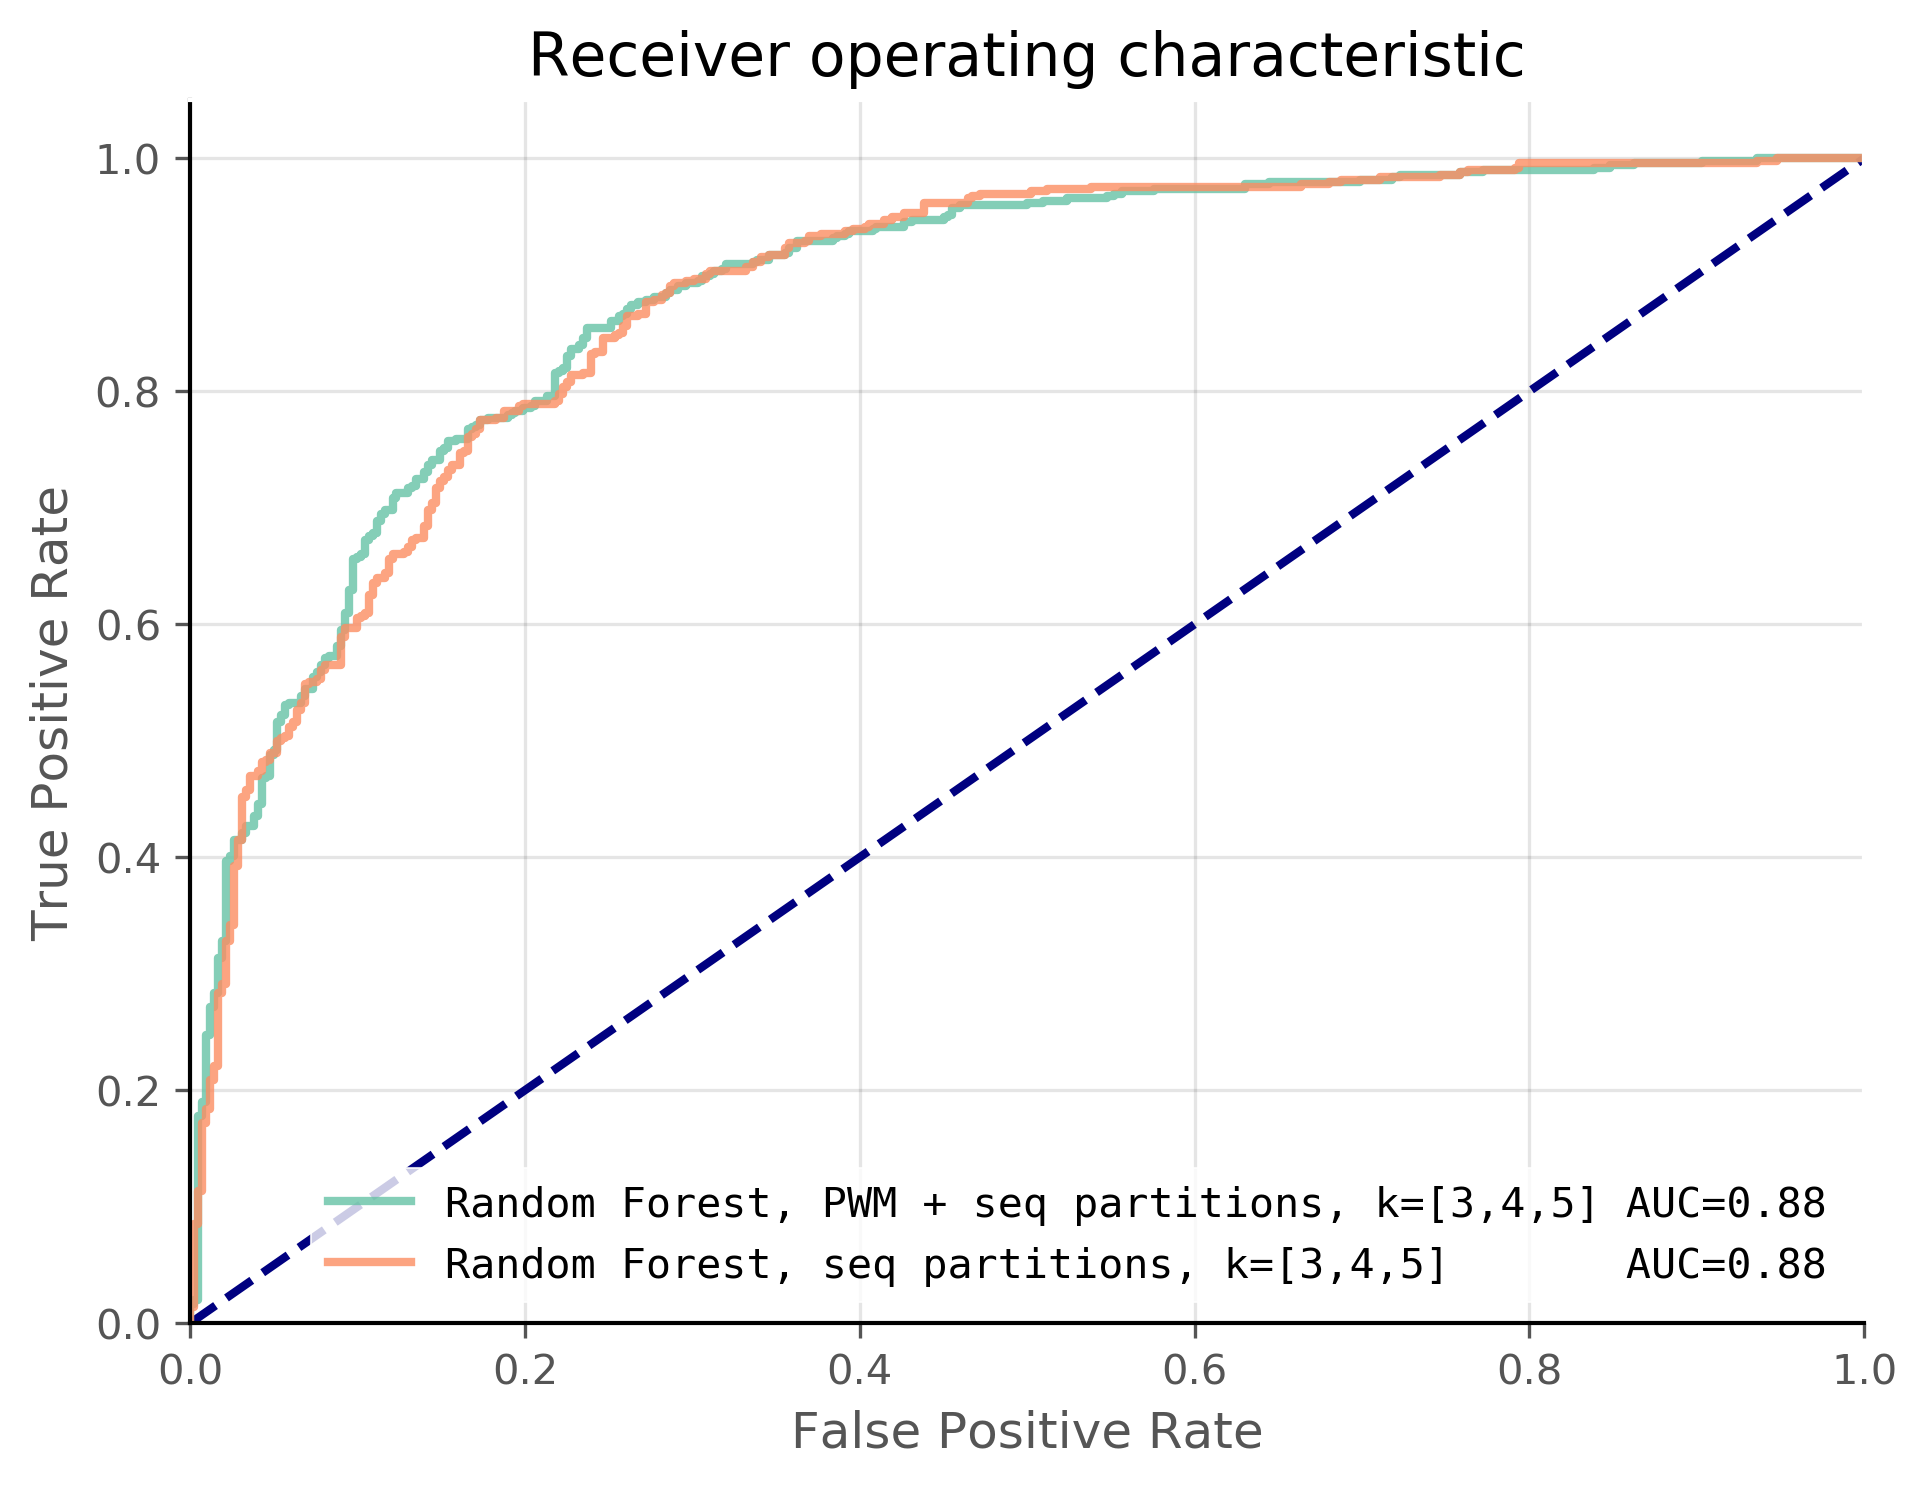

In [73]:
print("Accuracy: ", parted_kmer_pwm_rf.accuracy)
print("Recall: ", parted_kmer_pwm_rf.recall)
print("F1: ", parted_kmer_pwm_rf.f1)
print("AUROC: ", parted_kmer_pwm_rf.auroc)
print("AUPRC: ", parted_kmer_pwm_rf.auprc)
plotting_utils.plot_auroc({
    "Random Forest, PWM + seq partitions, k=[3,4,5]": parted_kmer_pwm_rf,
    "Random Forest, seq partitions, k=[3,4,5]": parted_kmer_rf,
})

In [81]:
parted_kmer_pwm_test_perf = model_utils.generate_model_perf(
    parted_kmer_pwm_test_data[1],  # Array of 0/1
    parted_kmer_pwm_model.predict_proba(parted_kmer_pwm_test_data[0])[:, 1].flatten(),
    multiclass=False,
)
parted_kmer_pwm_test_perf.auroc, parted_kmer_pwm_test_perf.auprc

(0.8339614540597271, 0.8091692328220828)

## PWMs alone.

We know that PWMs don't really add a lot to the model's performance, but does it do well by itself?

In [84]:
pwm_train_data = parted_kmer_pwm_train_data[0][:, -193:], parted_kmer_pwm_train_data[1]
pwm_valid_data = parted_kmer_pwm_valid_data[0][:, -193:], parted_kmer_pwm_valid_data[1]
pwm_test_data = parted_kmer_pwm_test_data[0][:, -193:], parted_kmer_pwm_test_data[1]
print(pwm_train_data[0].shape)
print(pwm_valid_data[0].shape)
print(pwm_test_data[0].shape)

(7323, 193)
(916, 193)
(916, 193)


In [59]:
# Get an idea of what the PWM matrix actually looks like
pwm_train_data[0]

array([[1163., 1307.,    0., ...,    0., 1342.,    0.],
       [ 508.,  587.,    0., ...,    0.,  404.,    0.],
       [ 873., 1402.,    0., ...,    0.,  810.,    0.],
       ...,
       [1492., 1097.,    0., ...,    0.,  956.,    0.],
       [ 265.,  327.,    0., ...,    0.,  202.,    0.],
       [ 209.,  194.,    0., ...,    0.,  193.,    0.]])

103836.2509900314
82910.0


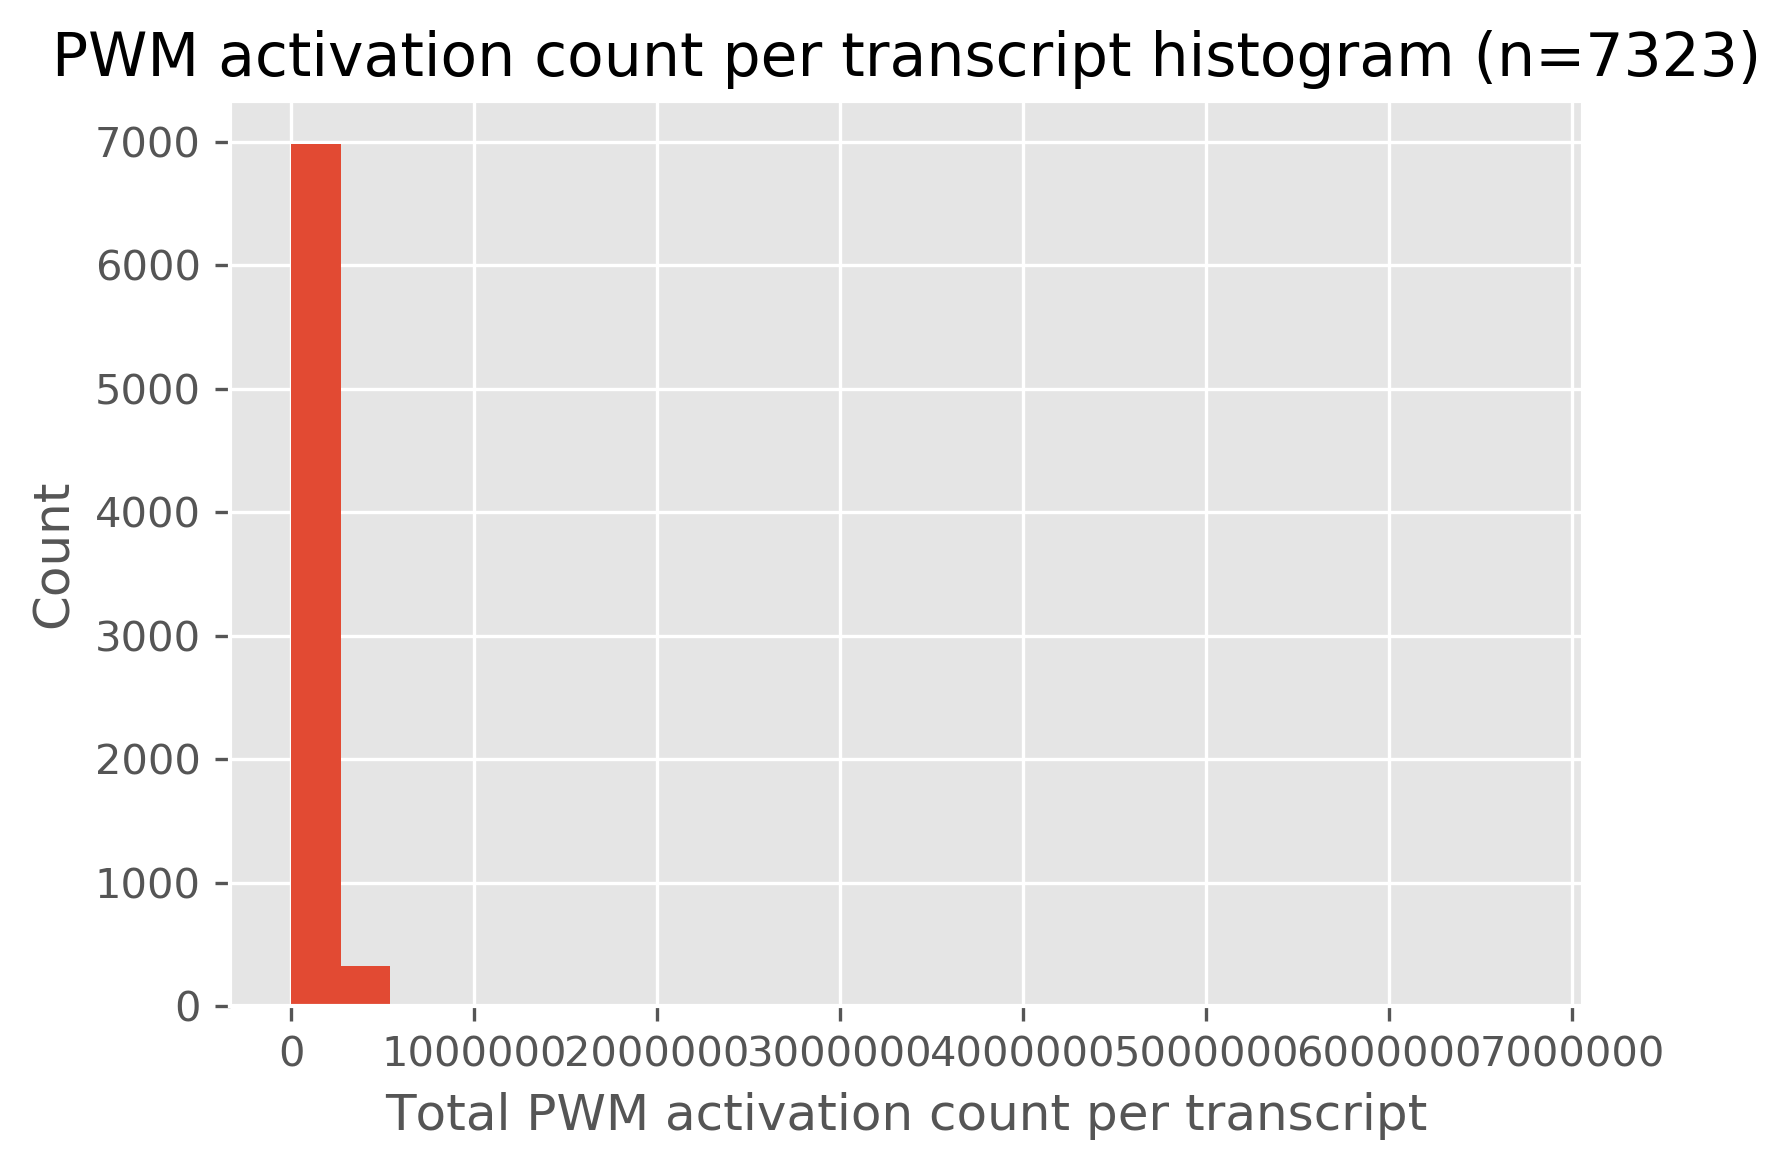

In [60]:
# Average number of PWM activations
print(np.mean(np.sum(pwm_train_data[0], axis=1)))
print(np.median(np.sum(pwm_train_data[0], axis=1)))
fig, ax = plt.subplots(dpi=300)
ax.hist(np.sum(pwm_train_data[0], axis=1), bins=25)
ax.set_xlabel("Total PWM activation count per transcript")
ax.set_ylabel("Count")
ax.set_title("PWM activation count per transcript histogram (n=%i)" % pwm_train_data[0].shape[0])
ax.grid(True)
plt.tight_layout()

145.91970503891847
146.0


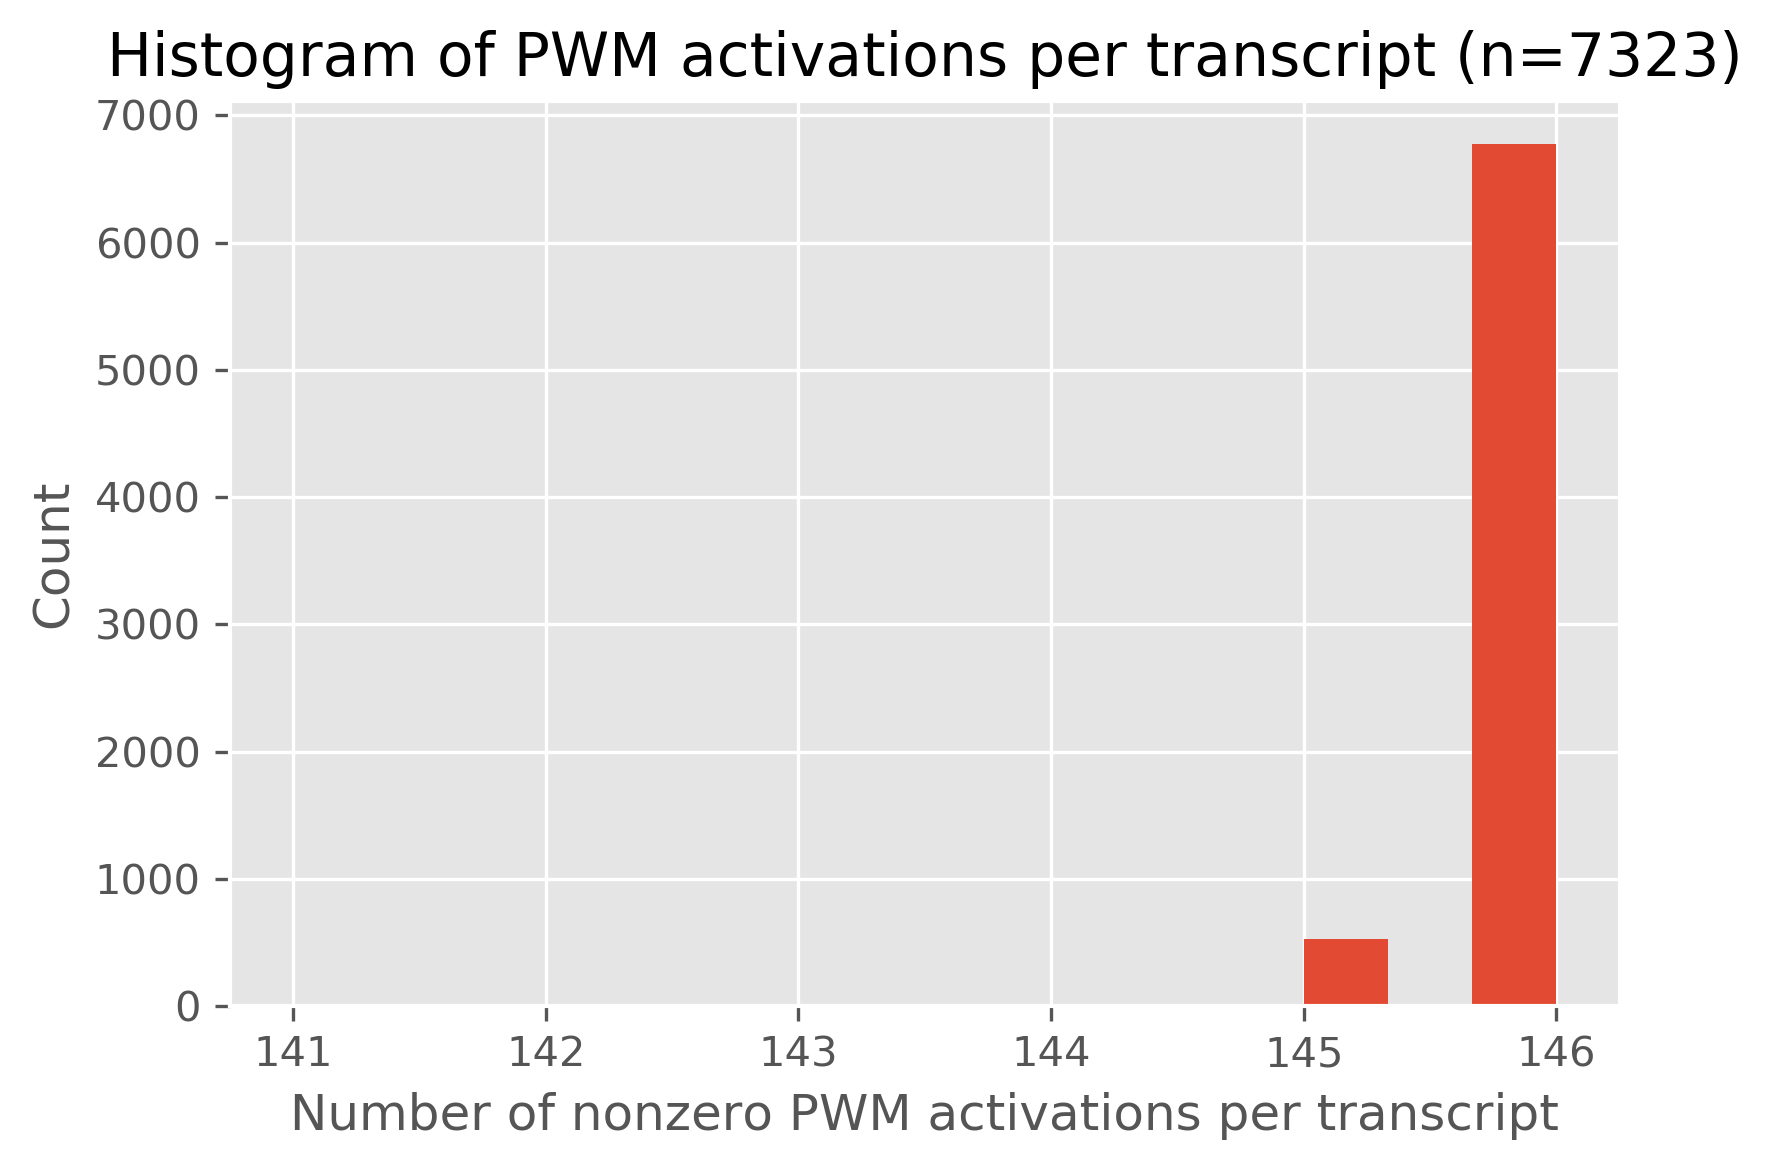

In [61]:
# Average number of non-zero PWM activations
print(np.mean(np.sum(pwm_train_data[0] > 0, axis=1)))
print(np.median(np.sum(pwm_train_data[0] > 0, axis=1)))
fig, ax = plt.subplots(dpi=300)
ax.hist(np.sum(pwm_train_data[0] > 0, axis=1), bins=15)
ax.set_xlabel("Number of nonzero PWM activations per transcript")
ax.set_ylabel("Count")
ax.set_title("Histogram of PWM activations per transcript (n=%i)" % pwm_train_data[0].shape[0])
ax.grid(True)
plt.tight_layout()

In [85]:
importlib.reload(model_utils)
pwm_param_combos_overall_perf = []
pwm_param_combos_models = []

for n_est, crit, depth, min_samp, max_feat, weight in tqdm.tqdm_notebook(rf_param_combos):
    rf_param_dict = {
        "n_estimators": n_est,
        "criterion": crit,
        "max_depth": depth,
        "min_samples_leaf": min_samp,
        "max_features": max_feat,
        "class_weight": weight,
        "n_jobs": 32,
        "random_state": 39282,
    }

    pwm_model, pwm_rf = single_train(
        RandomForestClassifier(**rf_param_dict),
        pwm_train_data,
        pwm_valid_data,
        verbose=False,
    )
    pwm_param_combos_models.append(pwm_model)
    pwm_param_combos_overall_perf.append(pwm_rf)

In [92]:
pwm_aurocs = [p.auroc for p in pwm_param_combos_overall_perf]
pwm_auprcs = [p.auprc for p in pwm_param_combos_overall_perf]
pwm_best_idx = np.argmax(pwm_aurocs)
print(pwm_aurocs[pwm_best_idx], pwm_auprcs[pwm_best_idx])

pwm_model = pwm_param_combos_models[pwm_best_idx]
pwm_rf = pwm_param_combos_overall_perf[pwm_best_idx]

0.7832281213423643 0.7895634464205614


In [89]:
pwm_test_perf = model_utils.generate_model_perf(
    pwm_test_data[1],  # Array of 0/1
    pwm_model.predict_proba(pwm_test_data[0])[:, 1].flatten(),
    multiclass=False,
)
pwm_test_perf.auroc, pwm_test_perf.auprc

(0.4414154183761092, 0.48647546284289855)

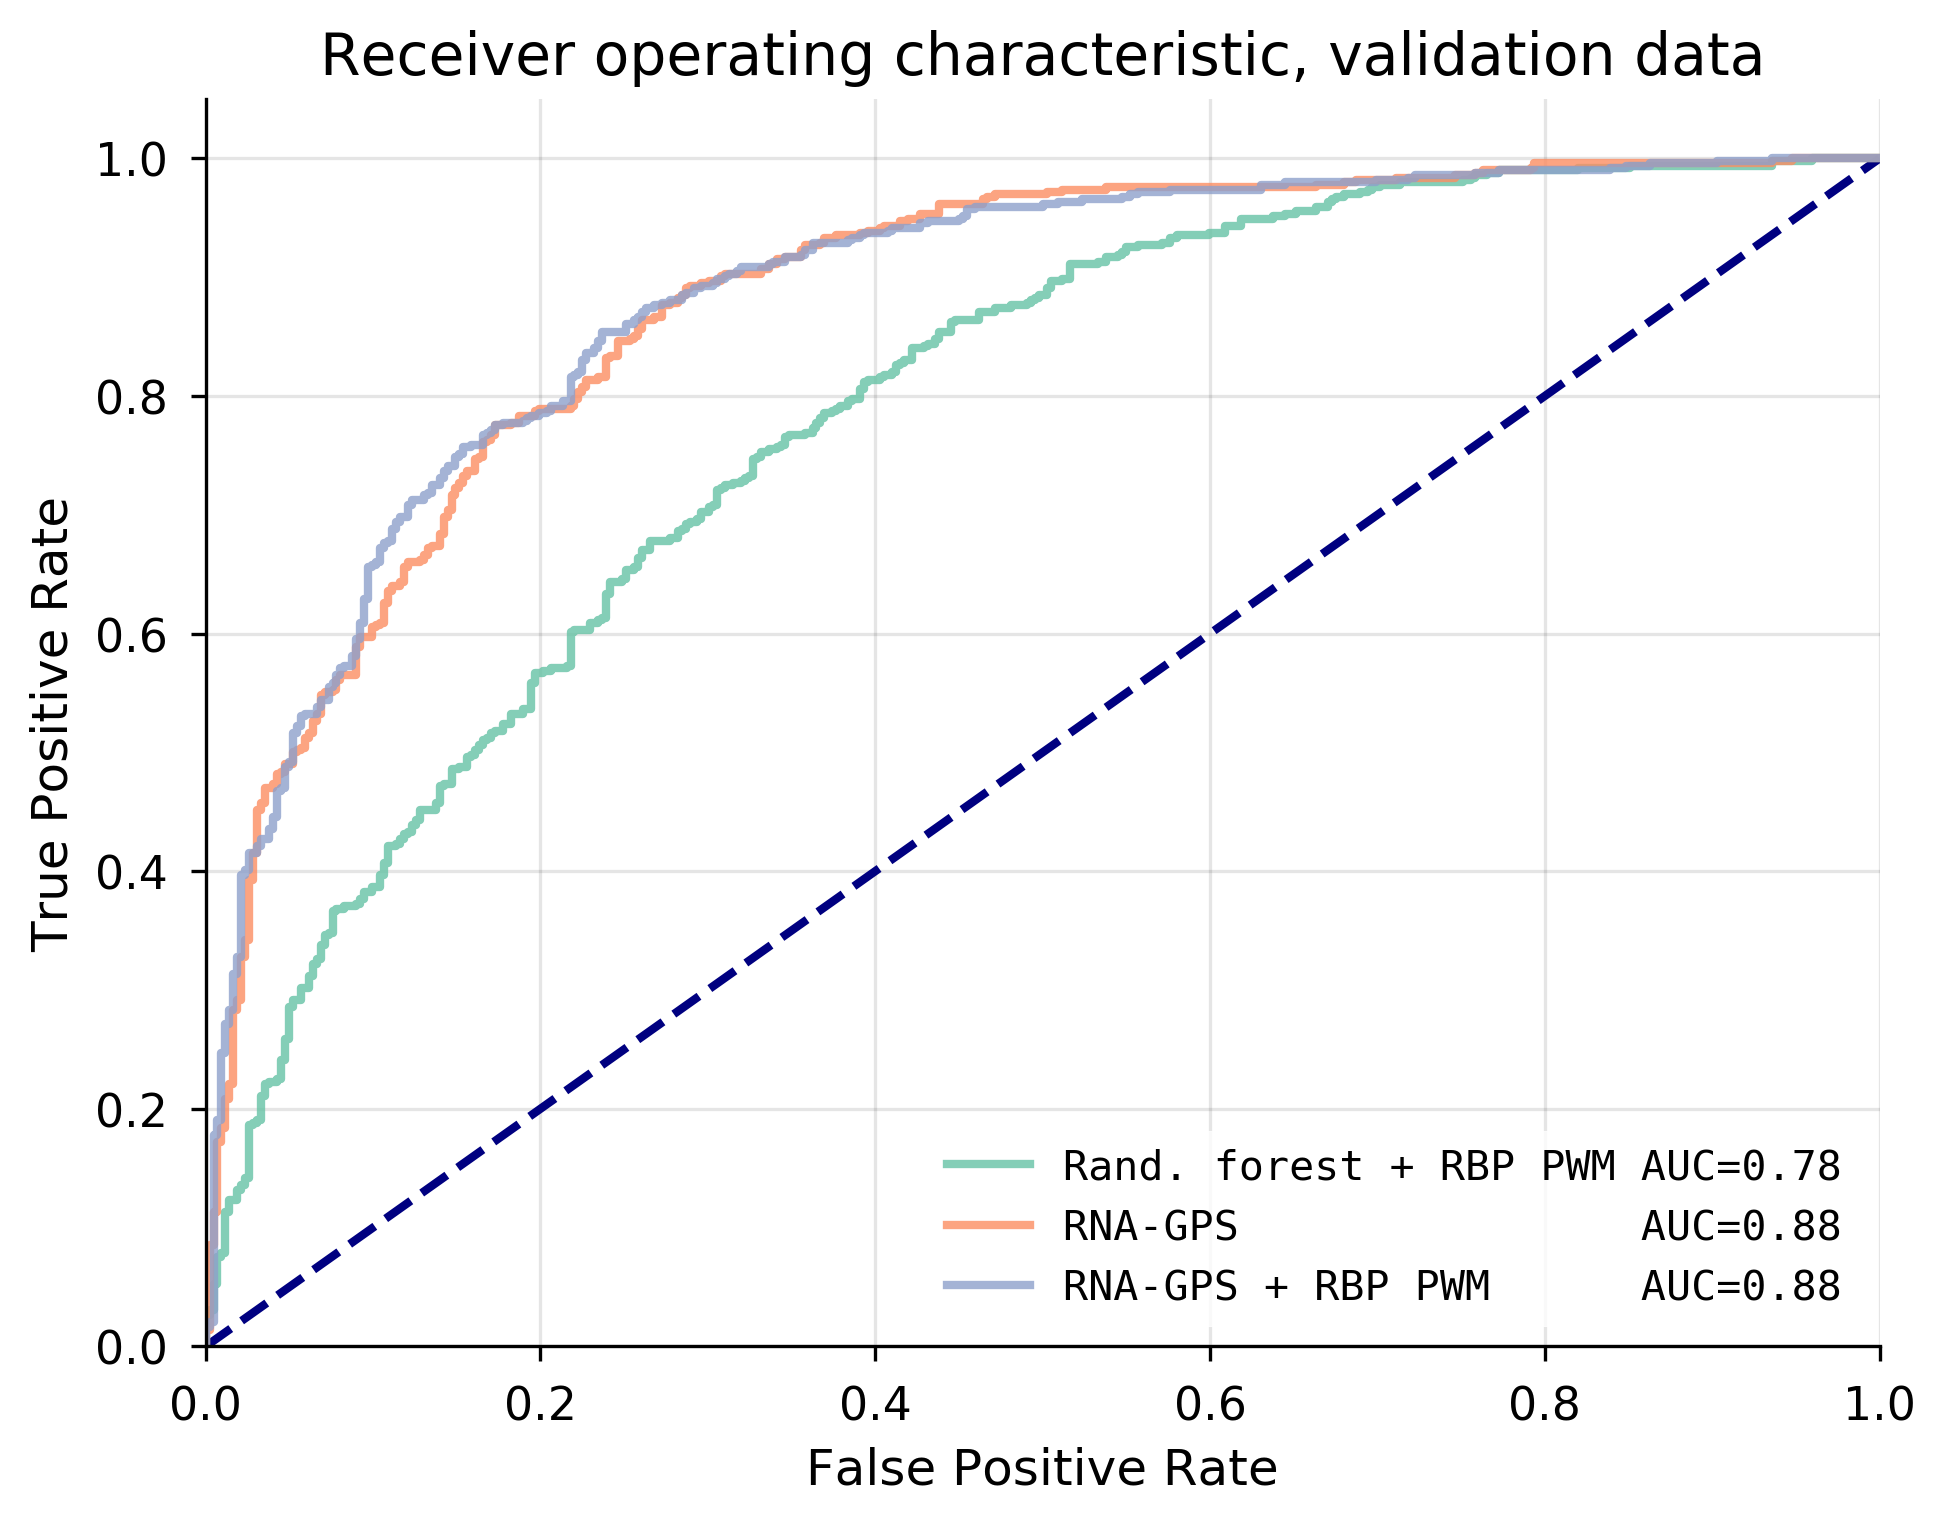

In [106]:
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {
        "Rand. forest + RBP PWM": pwm_rf,
        "RNA-GPS": parted_kmer_rf,
        "RNA-GPS + RBP PWM": parted_kmer_pwm_rf,
    },
    title="Receiver operating characteristic, validation data",
    fname=os.path.join(PLOT_DIR, "pwm_nuc_cyto_auroc_valid.pdf"),
)

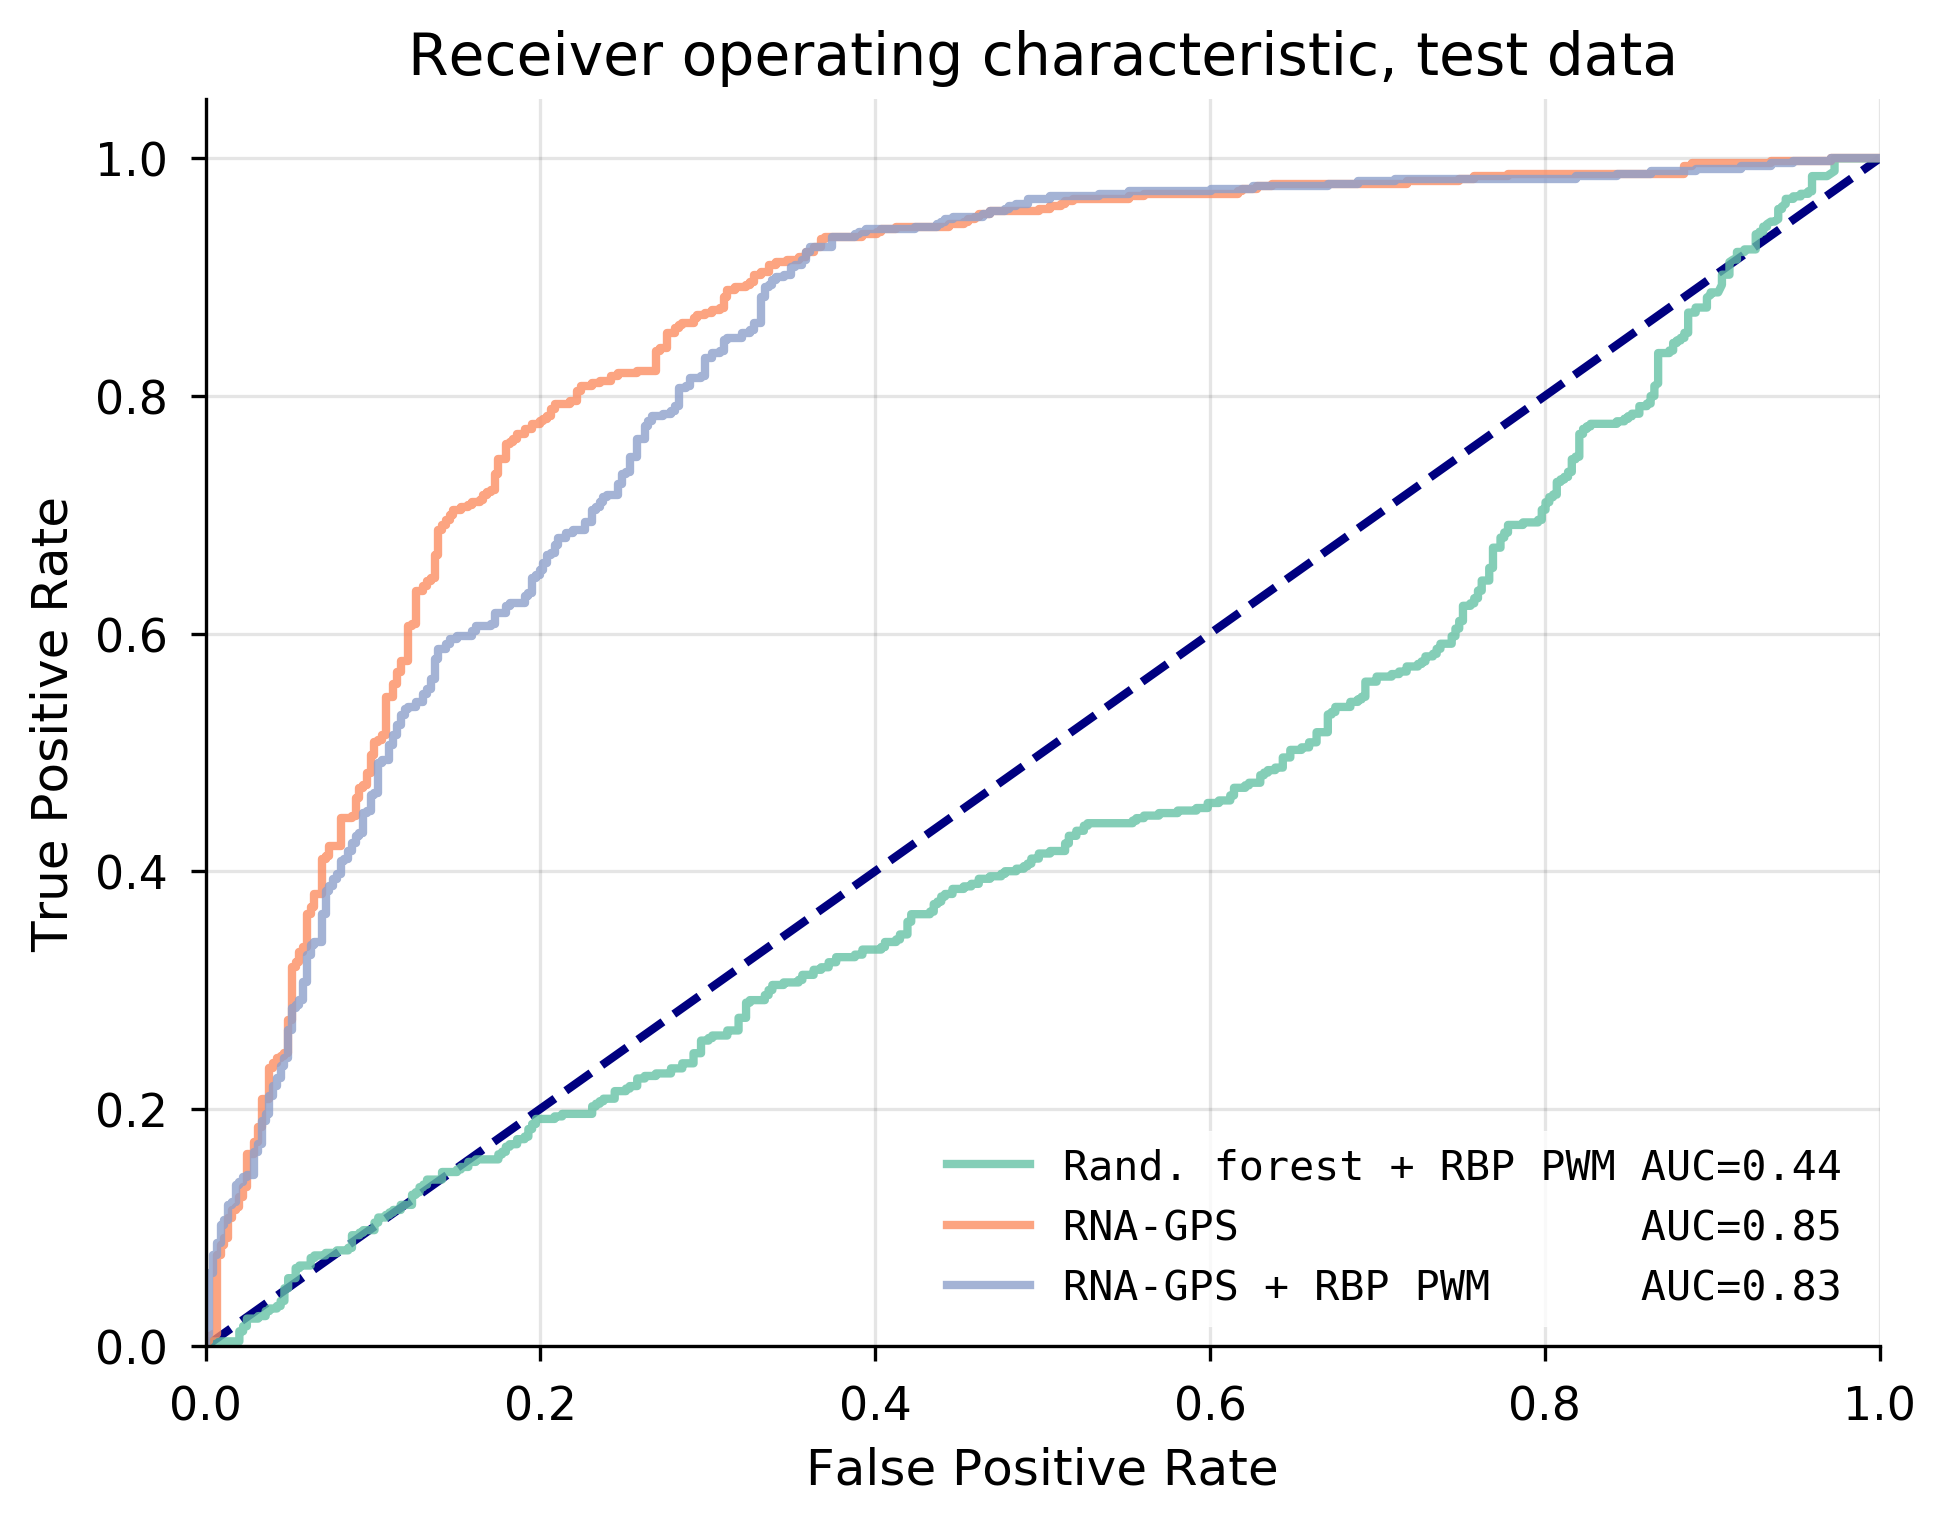

In [107]:
importlib.reload(plotting_utils)
plotting_utils.plot_auroc(
    {
        "Rand. forest + RBP PWM": pwm_test_perf,
        "RNA-GPS": parted_kmer_test_perf,
        "RNA-GPS + RBP PWM": parted_kmer_pwm_test_perf,
    },
    title="Receiver operating characteristic, test data",
    fname=os.path.join(PLOT_DIR, "pwm_nuc_cyto_auroc_test.pdf"),
)